In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from collections import defaultdict

 ### time_periods = [("2022-10-17", "2022-10-21"), ("2022-11-08","2022-11-11"), ("2022-11-15","2022-11-18"),
 ###          ("2022-11-22","2022-11-25"), ("2022-11-29","2022-12-02"), ("2022-12-05","2022-12-09"), 
 ###          ("2022-12-12","2022-12-16"), ("2022-12-19","2022-12-23")]

In [61]:
time_periods = [("2022-10-17", "2022-10-21"), ("2022-11-08","2022-11-11"), ("2022-11-15","2022-11-18"),
           ("2022-11-22","2022-11-25"), ("2022-11-29","2022-12-02"), ("2022-12-05","2022-12-09"), 
           ("2022-12-12","2022-12-16"), ("2022-12-19","2022-12-23")]

* 299 Т1к после ТО
* 307 P1контура
* 309 Р2контура
* 313 Рградирни
* 315 Т1к перед ТО
* 317 Т2к перед ТО
* 319 Т2к после ТО
* 325 Т2к выхТО1
* 327 Твозвуха
* 381 Iвг1
* 395 Iвг2
* 396 Iвг3
* 460 Т2к выхТО2
* 461 Т2к выхТО3
* 462 Т2к выхТО4
* 463 Т2к выхТО5
* 480 Q1контура
* 481 Q2контура
#### Second loop pumps id
* 406 2-1
* 407 2-2
* 408 2-3
* 409 2-4

In [62]:
# name conventions 
# df_2loop_fin - df of 2nd loop (P, Q, Temperatures). Fin stands for status of dataframe

In [63]:
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))
from analytics import WaterTemperatures, DissipatedHeat

In [64]:
from preprocessing import CsvRefactorer

In [65]:
# load and read csvs
df_refac = CsvRefactorer.read_csv("041022_to_231222.csv")
df_refac_pumps = CsvRefactorer.read_csv("I_pumps_200921_to_231222.csv", index_range=("041022", "231222"))

In [66]:
# get all ids
ids = df_refac.df["ID"].unique()
ids_pumpms = df_refac_pumps.df["ID"].unique()
ids

array([299, 307, 309, 313, 315, 317, 319, 325, 327, 381, 395, 396, 460,
       461, 462, 463, 480, 481])

In [67]:
# select by ids
# automate it by creating interface (function) that returns array of array of dfs or just use loop
dfs_array_ids = []

for i in [[309, 317, 319, 325, 327, 481, 315, 299], [381], [395]]:
    dfs_array_ids.append(df_refac.select_by_ids(i))
for i in [[406], [407], [408], [409]]:
    dfs_array_ids.append(df_refac_pumps.select_by_ids(i))
for i in [[460], [461], [462], [463]]:
    dfs_array_ids.append(df_refac.select_by_ids(i))

In [68]:
# groupby by 60min
dfs_array_gr = []
for i in dfs_array_ids:
    dfs_array_gr.append(df_refac.min_frac_groupby("60", *i))


In [69]:
# merge dfs that do meet requirements (create proper architecture of df)
dfs_array = []
for i in dfs_array_gr:
    dfs_array.append(df_refac.create_df_from_dfs("ID", i))

In [70]:
# adding Qdis (heat dissipated in 2nd loop)
dfs_array[0]["Qdis"] = (dfs_array[0][481]*1.16*(dfs_array[0][319] - dfs_array[0][317]))/4
dfs_array[0]["WFR1"] = dfs_array[0]["Qdis"]/(1.16*(dfs_array[0][325] - dfs_array[0][317]))
dfs_array[0]["WFR2"] = dfs_array[0]["Qdis"]/(1.16*(dfs_array[7][460] - dfs_array[0][317]))
dfs_array[0]["WFR3"] = dfs_array[0]["Qdis"]/(1.16*(dfs_array[8][461] - dfs_array[0][317]))
dfs_array[0]["WFR4"] = dfs_array[0]["Qdis"]/(1.16*(dfs_array[9][462] - dfs_array[0][317]))
dfs_array

[                          309        317        319        325        327  \
 Timestamp                                                                   
 2022-10-04 09:00:00  0.010000  17.400000  22.593903  22.529630   0.124390   
 2022-10-04 10:00:00  0.010000  17.400000  22.563000  22.486956   4.122222   
 2022-10-04 11:00:00  0.010000  17.400000  22.668617  22.400000   6.481858   
 2022-10-04 12:00:00  0.010000  17.400000  22.982447  22.362765   7.913699   
 2022-10-04 13:00:00  0.010000  17.400000  23.344086  22.299999   8.110599   
 ...                       ...        ...        ...        ...        ...   
 2022-12-23 11:00:00  0.420000  19.979897  25.958673  25.834536 -20.816818   
 2022-12-23 12:00:00  0.420000  20.275000  26.335567  26.190863 -20.190611   
 2022-12-23 13:00:00  0.420000  19.046907  25.251282  25.104188 -20.048624   
 2022-12-23 14:00:00  0.420000  18.431579  24.616043  24.479487 -19.793518   
 2022-12-23 15:00:00  0.415946  18.021488  22.361654  22.163235 

In [71]:
# split each df on time periods
# array of dict where each dict is df splitted by time periods (k - tp, value - df for this period)
df_array_tp = []
for i in dfs_array:
    df_array_tp.append(df_refac.select_time_period(i, time_periods))
df_array_tp, len(df_array_tp)

([{'2022-10-17 2022-10-21':                           309        317        319        325       327  \
   Timestamp                                                                  
   2022-10-17 14:00:00  0.302121  13.584466  15.794059  15.220488  9.898190   
   2022-10-17 15:00:00  0.446229  15.415349  18.245299  18.151709  9.341818   
   2022-10-17 16:00:00  0.450000  21.552917  26.007083  25.768750  7.153191   
   2022-10-17 17:00:00  0.450000  24.913636  30.119289  29.690909  6.018009   
   2022-10-17 18:00:00  0.450000  23.436021  29.602674  29.117838  5.754091   
   ...                       ...        ...        ...        ...       ...   
   2022-10-21 15:00:00  0.450000  23.870270  30.184325  29.795108  8.480365   
   2022-10-21 16:00:00  0.450000  23.861827  30.172728  29.816230  7.640000   
   2022-10-21 17:00:00  0.450000  23.733690  30.082540  29.697827  6.728302   
   2022-10-21 18:00:00  0.450000  22.567805  29.140000  28.708253  6.294660   
   2022-10-21 19:00:00  0.4

In [72]:
tps = list(df_array_tp[0].keys())
tps

['2022-10-17 2022-10-21',
 '2022-11-08 2022-11-11',
 '2022-11-15 2022-11-18',
 '2022-11-22 2022-11-25',
 '2022-11-29 2022-12-02',
 '2022-12-05 2022-12-09',
 '2022-12-12 2022-12-16',
 '2022-12-19 2022-12-23']

In [73]:
df_merged_tps = df_refac.merge_dfs_by_tp(df_array_tp, tps, index=0)
df_merged_tps

defaultdict(list,
            {'2022-10-17 2022-10-21': [                          309        317        319        325       327  \
              Timestamp                                                                  
              2022-10-17 14:00:00  0.302121  13.584466  15.794059  15.220488  9.898190   
              2022-10-17 15:00:00  0.446229  15.415349  18.245299  18.151709  9.341818   
              2022-10-17 16:00:00  0.450000  21.552917  26.007083  25.768750  7.153191   
              2022-10-17 17:00:00  0.450000  24.913636  30.119289  29.690909  6.018009   
              2022-10-17 18:00:00  0.450000  23.436021  29.602674  29.117838  5.754091   
              ...                       ...        ...        ...        ...       ...   
              2022-10-21 15:00:00  0.450000  23.870270  30.184325  29.795108  8.480365   
              2022-10-21 16:00:00  0.450000  23.861827  30.172728  29.816230  7.640000   
              2022-10-21 17:00:00  0.450000  23.733690  3

In [74]:
# df not filtered
df_tps = df_refac.create_df_for_tp(df_merged_tps, tps)

In [75]:
md_dh = 0.05 # share threshold
dh_anals = DissipatedHeat(md_dh)
ind = 0 # index of df which to filter
for dates in tps:
    # filter df by md for certain column
    df_tps[dates], r =  dh_anals.df_md_filter(df_tps[dates], "Qdis")
df_tps

{'2022-10-17 2022-10-21':                       309        317        319        325       327  \
 Timestamp                                                              
 2022-10-17 18:00:00  0.45  23.436021  29.602674  29.117838  5.754091   
 2022-10-17 19:00:00  0.45  23.230688  29.451052  28.993011  5.632039   
 2022-10-17 20:00:00  0.45  23.113757  29.384408  28.931720  5.305963   
 2022-10-17 21:00:00  0.45  22.951052  29.242487  28.786559  4.877073   
 2022-10-17 22:00:00  0.45  22.781081  29.115676  28.628192  4.478302   
 ...                   ...        ...        ...        ...       ...   
 2022-10-21 14:00:00  0.45  23.743889  30.067760  29.683709  8.539908   
 2022-10-21 15:00:00  0.45  23.870270  30.184325  29.795108  8.480365   
 2022-10-21 16:00:00  0.45  23.861827  30.172728  29.816230  7.640000   
 2022-10-21 17:00:00  0.45  23.733690  30.082540  29.697827  6.728302   
 2022-10-21 18:00:00  0.45  22.567805  29.140000  28.708253  6.294660   
 
                        

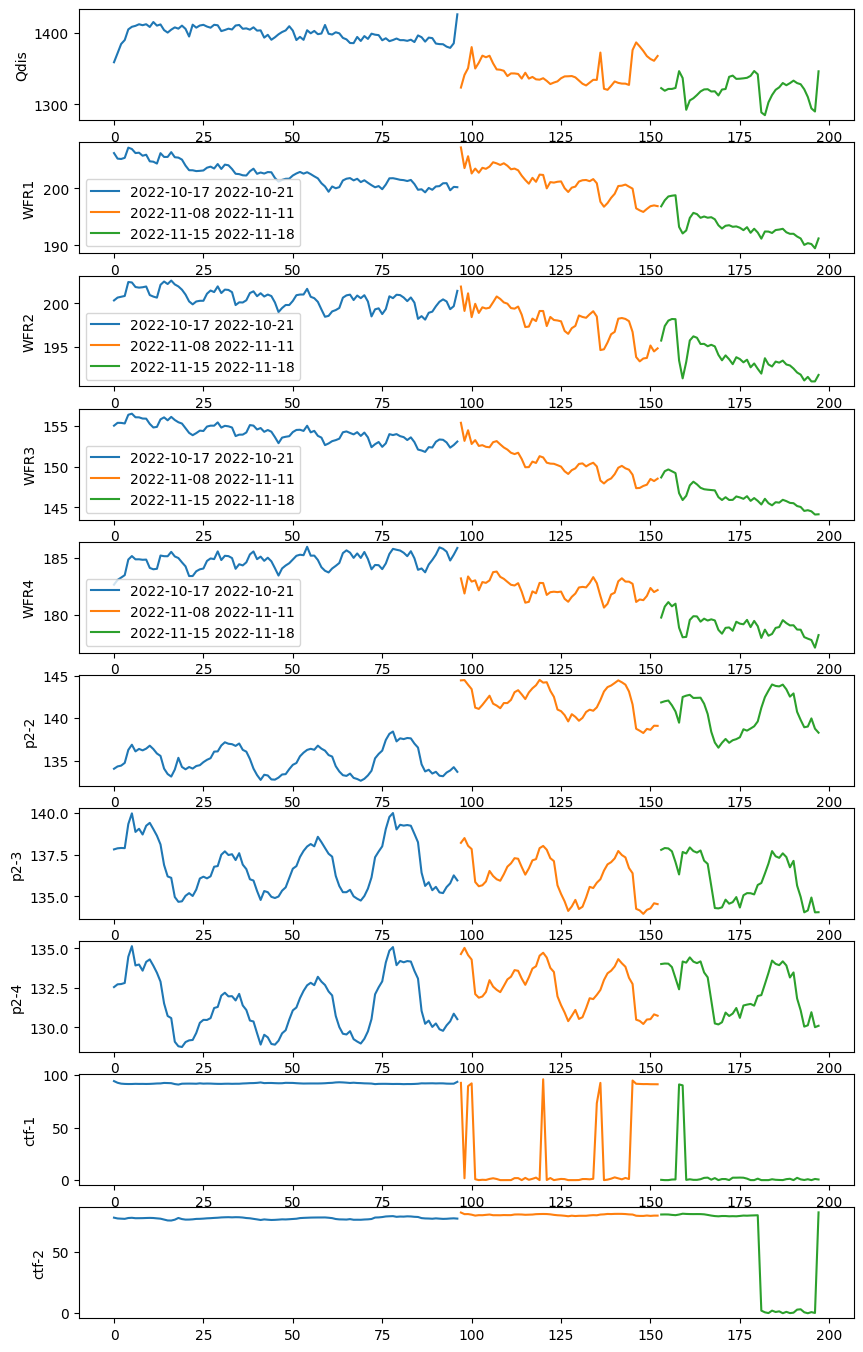

In [76]:
fig, axs = plt.subplots(10,1, figsize=(10,17))
st = 0

# take only 3 first periods
for k, v in list(df_tps.items())[:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].set_ylabel("Qdis")
    
    axs[1].plot(X, v["WFR1"], label=k)
    axs[1].set_ylabel("WFR1")
    axs[1].legend()
    
    axs[2].plot(X, v["WFR2"], label=k)
    axs[2].set_ylabel("WFR2")
    axs[2].legend()
    
    axs[3].plot(X, v["WFR3"], label=k)
    axs[3].set_ylabel("WFR3")
    axs[3].legend()
    
    axs[4].plot(X, v["WFR4"], label=k)
    axs[4].set_ylabel("WFR4")
    axs[4].legend()
    # p 2-1 was not under operation
#     axs[1].plot(X, v[406], label=k)
#     axs[1].set_ylabel("p2-1")
    
    axs[5].plot(X, v[407], label=k)
    axs[5].set_ylabel("p2-2")
    
    axs[6].plot(X, v[408], label=k)
    axs[6].set_ylabel("p2-3")
    
    axs[7].plot(X, v[409], label=k)
    axs[7].set_ylabel("p2-4")
    
    axs[8].plot(X, v[381], label=k)
    axs[8].set_ylabel("ctf-1")
    
    axs[9].plot(X, v[395], label=k)
    axs[9].set_ylabel("ctf-2")

    st += len(v)
# plt.legend()

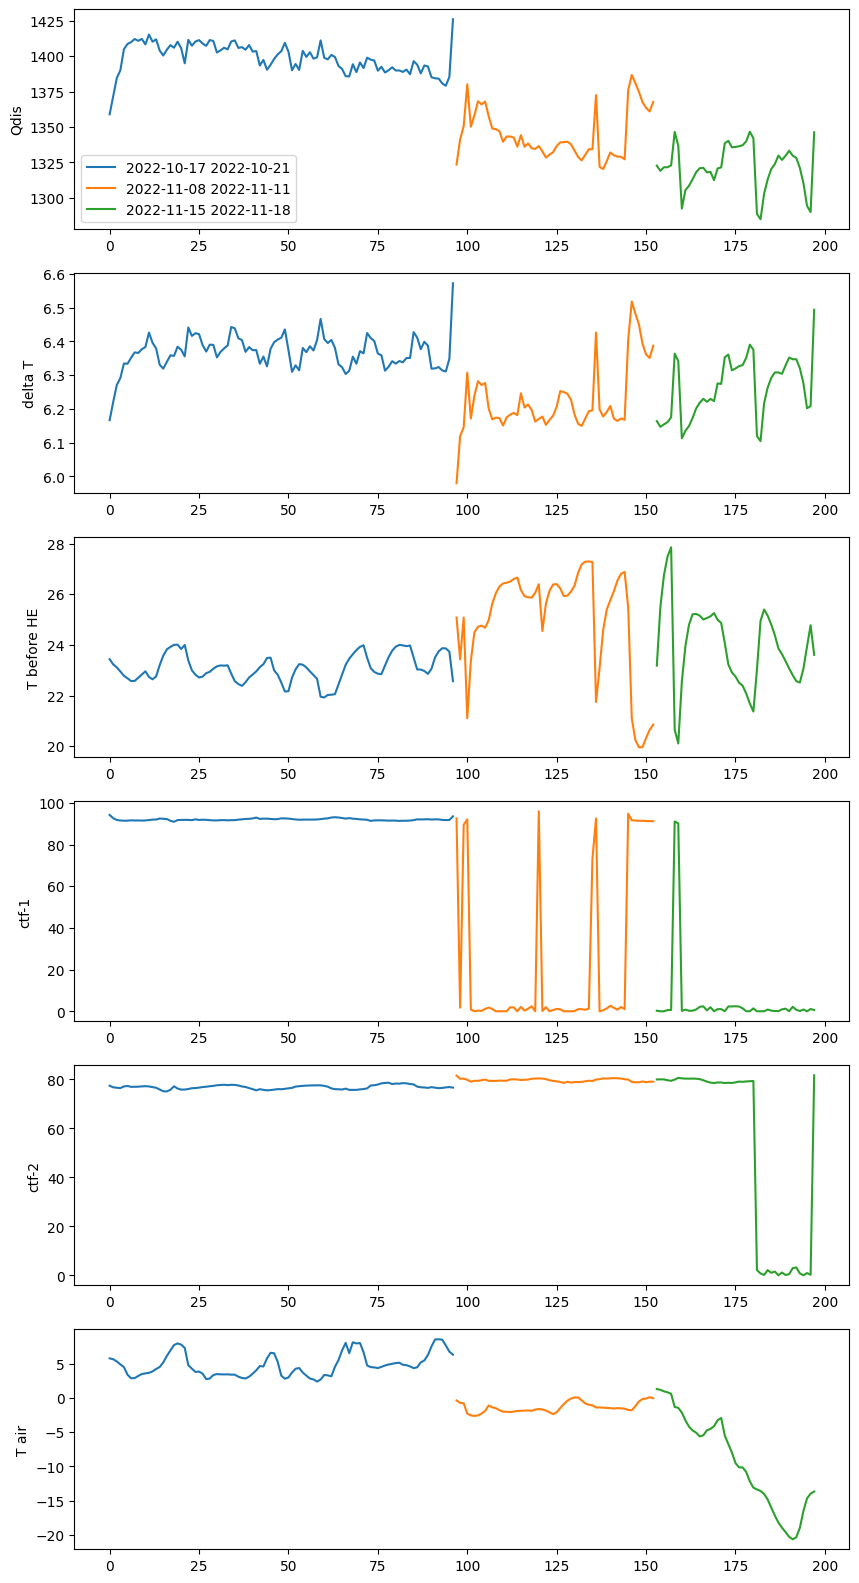

In [77]:
fig, axs = plt.subplots(6,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps.items())[:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(X, v[319] - v[317], label=k)
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(X, v[317], label=k)
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(X, v[381], label=k)
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(X, v[395], label=k)
    axs[4].set_ylabel("ctf-2")
    
    axs[5].plot(X, v[327], label=k)
    axs[5].set_ylabel("T air")
    
    st += len(v)

### Upon results above:
* steady state condition should be obtained to suppress all feedback effects

### Most significant effect on temperatures and as result Qdis is made by
* ct fans operation
* outside (air) temperature

In [78]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

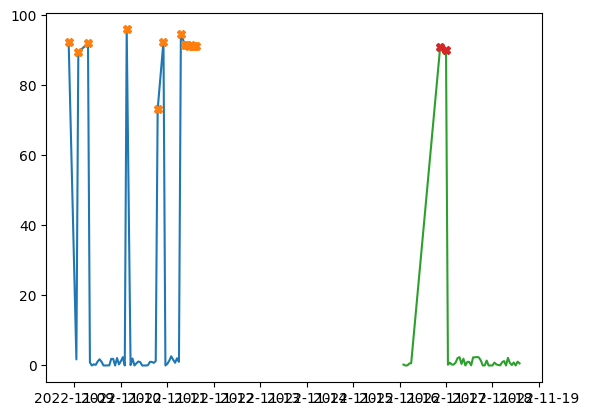

In [79]:
# lets start with removing non-stationary effects caused by ctf-1
# during tp1 there are no non-stasuonary efefcts caused by ctf-1 or ctf-2

tps23 = list(df_tps.keys())[1:3]

for i in tps23:
    plt.plot(df_tps[i][381])
    plt.plot(df_tps[i][381][df_tps[i][381] > 20], "X")

In [80]:
# quick filter of dfs by times when cft was under operation
df_tps_fd_ctf1 = df_tps.copy()
for i in tps23:
    df_tps_fd_ctf1[i] = df_tps_fd_ctf1[i][df_tps_fd_ctf1[i][381] < 5]

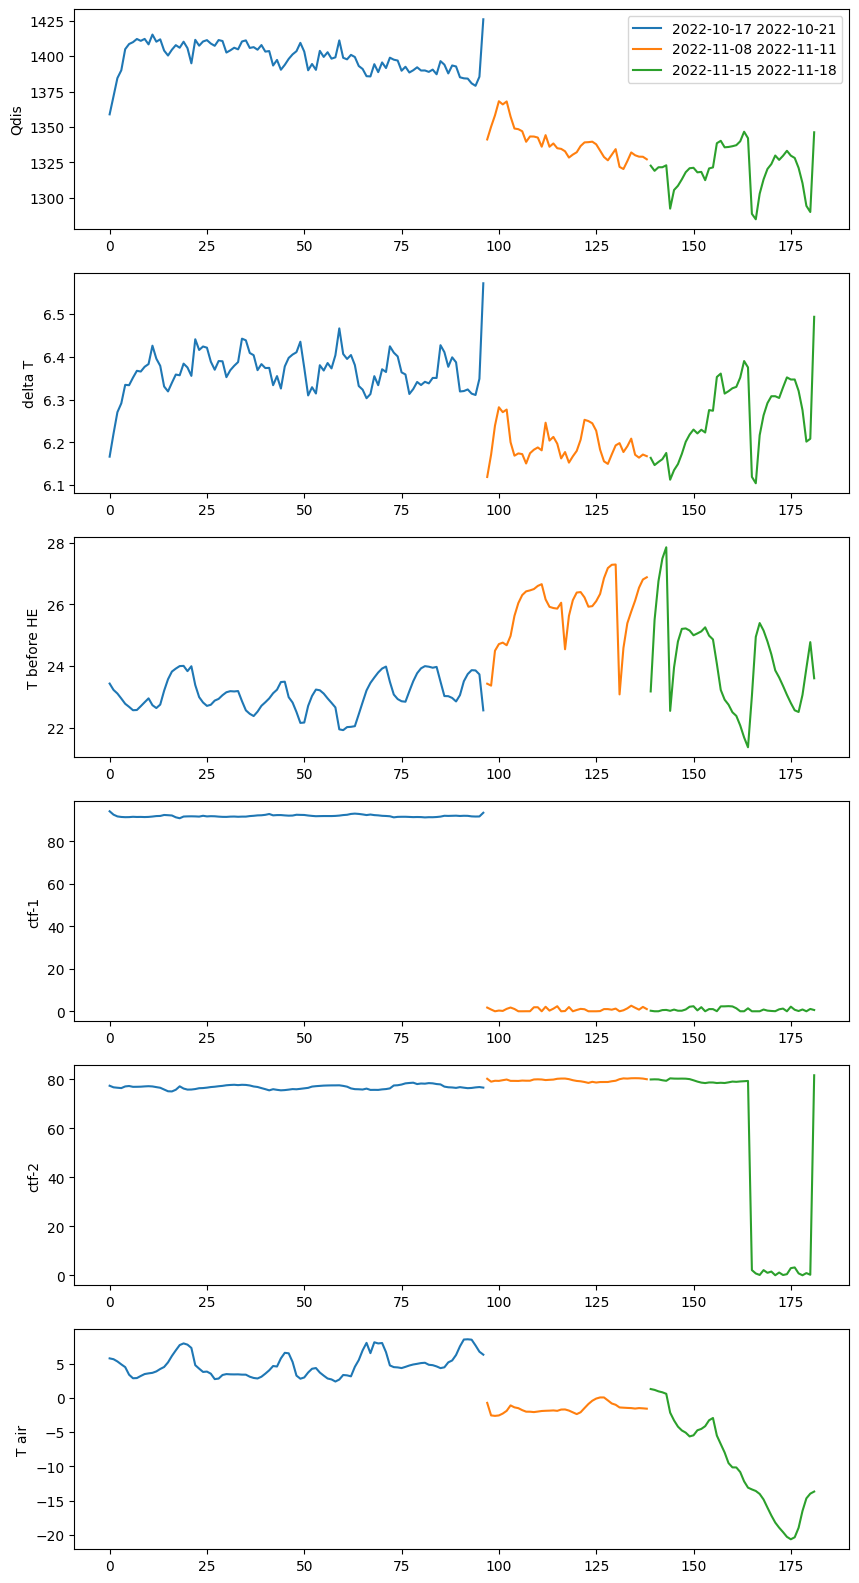

In [81]:
# quick filter of dfs by times when cft was under operation
fig, axs = plt.subplots(6,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps_fd_ctf1.items())[:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(X, v[319] - v[317], label=k)
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(X, v[317], label=k)
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(X, v[381], label=k)
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(X, v[395], label=k)
    axs[4].set_ylabel("ctf-2")
    
    axs[5].plot(X, v[327], label=k)
    axs[5].set_ylabel("T air")
    
    st += len(v)

### Filter (drop data) of dfs by the time when ctf1 was under operation

In [82]:
# query for indexes where cft1 was under operation
# add plus 2 hour to the right
from pandas.tseries.offsets import DateOffset

df_tps_ctf1 = df_tps.copy()
df_cft_indexes = defaultdict(list)
df_tp1_oper = defaultdict(list)
df_tps_fd_ctf1_1 = df_tps.copy()

for i in tps23:
    cft1_indexes = df_tps_fd_ctf1_1[i][df_tps_fd_ctf1_1[i][381] > 5].index # ctf1 under operation
    # extends the index plus 1 hour to the right
    for j in cft1_indexes:
        df_cft_indexes[i].append(j)
        df_cft_indexes[i].append(j + pd.Timedelta(1, "h"))
        df_cft_indexes[i].append(j + pd.Timedelta(2, "h"))
df_cft_indexes # given indexes removes from initial df

defaultdict(list,
            {'2022-11-08 2022-11-11': [Timestamp('2022-11-08 21:00:00'),
              Timestamp('2022-11-08 22:00:00'),
              Timestamp('2022-11-08 23:00:00'),
              Timestamp('2022-11-09 02:00:00'),
              Timestamp('2022-11-09 03:00:00'),
              Timestamp('2022-11-09 04:00:00'),
              Timestamp('2022-11-09 07:00:00'),
              Timestamp('2022-11-09 08:00:00'),
              Timestamp('2022-11-09 09:00:00'),
              Timestamp('2022-11-10 03:00:00'),
              Timestamp('2022-11-10 04:00:00'),
              Timestamp('2022-11-10 05:00:00'),
              Timestamp('2022-11-10 19:00:00'),
              Timestamp('2022-11-10 20:00:00'),
              Timestamp('2022-11-10 21:00:00'),
              Timestamp('2022-11-10 22:00:00'),
              Timestamp('2022-11-10 23:00:00'),
              Timestamp('2022-11-11 00:00:00'),
              Timestamp('2022-11-11 07:00:00'),
              Timestamp('2022-11-11 08:00:00'

In [83]:
# filter indexes
df_tps_ctf1_ind_fd = defaultdict(list)
for i in tps23:
    df_tps_ctf1_ind_fd[i] = set(df_tps_fd_ctf1_1[i].index).difference(set(df_cft_indexes[i]))
# df_tps_ctf1_ind_fd

In [84]:
# apply filter function to df upon filtered indexes
for i in tps23:
    df_tps_fd_ctf1_1[i] = df_tps_fd_ctf1_1[i].filter(items=df_tps_ctf1_ind_fd[i], axis=0).sort_index()
# df_tps_fd_ctf1

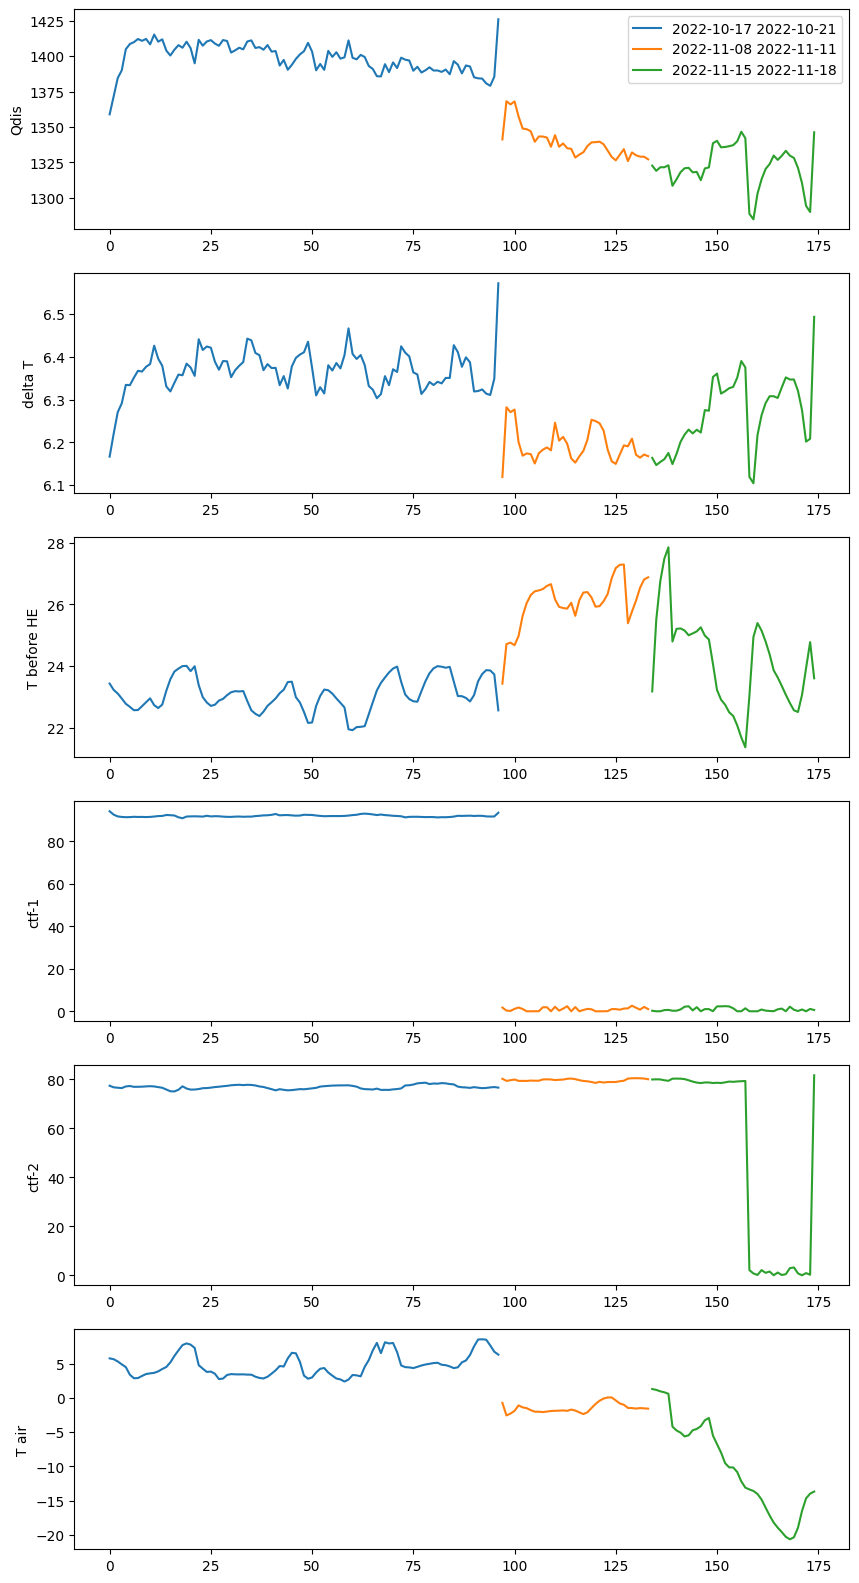

In [85]:
# filtered dfs by excluding time (plus 2 hour to right) when ctf1 was operated
fig, axs = plt.subplots(6,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps_fd_ctf1_1.items())[:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(X, v[319] - v[317], label=k)
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(X, v[317], label=k)
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(X, v[381], label=k)
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(X, v[395], label=k)
    axs[4].set_ylabel("ctf-2")
    
    axs[5].plot(X, v[327], label=k)
    axs[5].set_ylabel("T air")
    
    st += len(v)

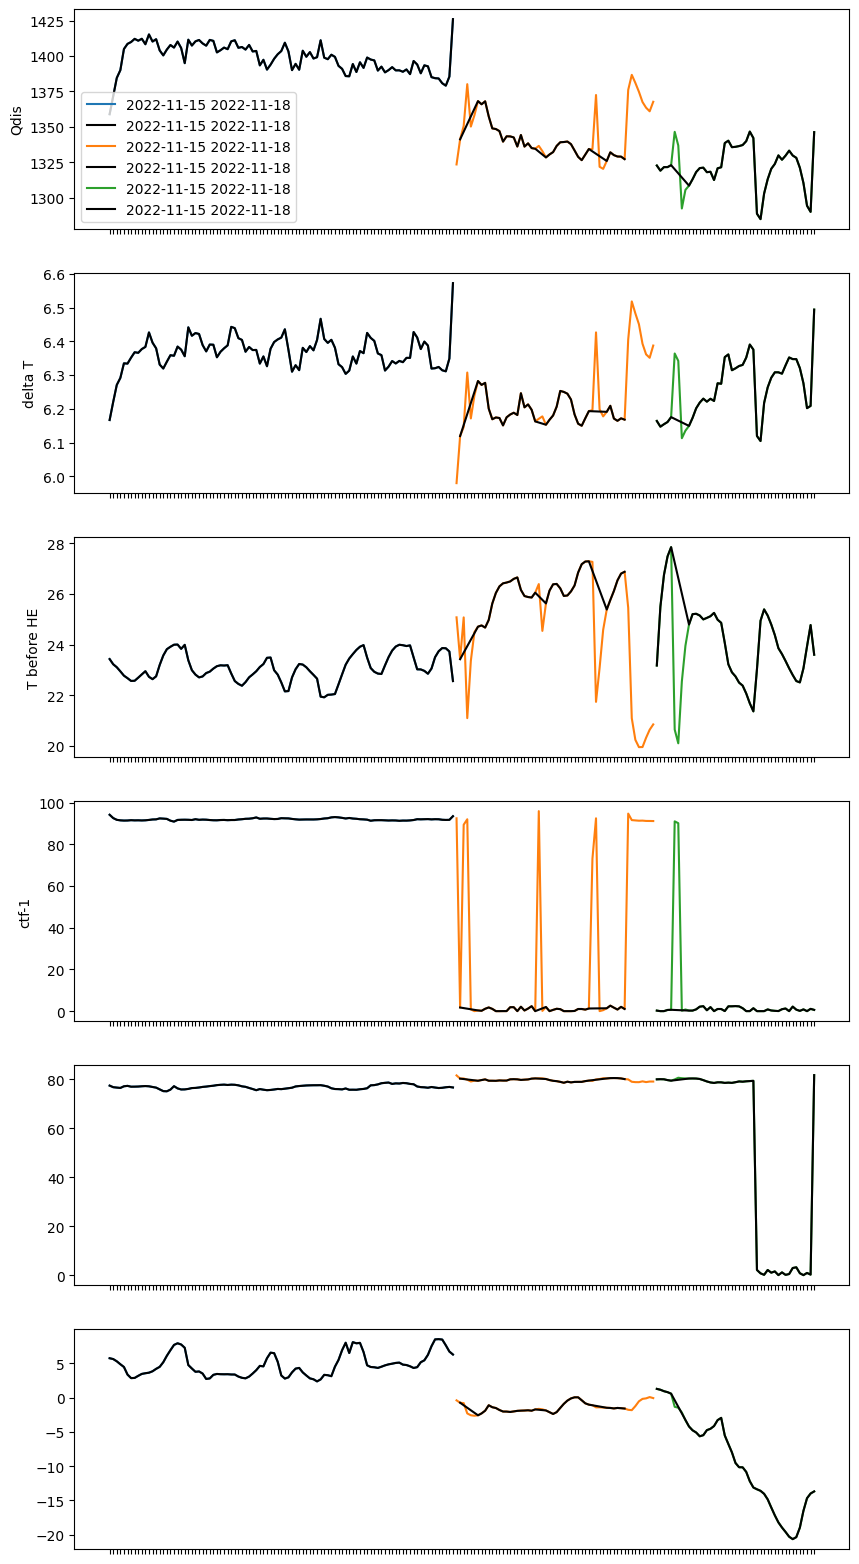

In [86]:
# filtered dfs by excluding time (plus 2 hour to right) when ctf1 was operated
# Try to combine filtered and no filtered data

fig, axs = plt.subplots(6,1, figsize=(10,20))
st = 0

# take only 3 first periods
for vb, va in zip(list(df_tps.values())[:3], list(df_tps_fd_ctf1_1.values())[:3]):
#     X = np.arange(0+st, len(v) + st, 1)
    Xb = vb.index.strftime('%Y-%m-%d %H:%M')
    Xa = va.index.strftime('%Y-%m-%d %H:%M')
    axs[0].plot(Xb, vb["Qdis"], label=k)
    axs[0].plot(Xa, va["Qdis"], color="black", label=k)
    axs[0].set_xticklabels([])
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(Xb, vb[319] - vb[317], label=k)
    axs[1].plot(Xa, va[319] - va[317], color="black", label=k)
    axs[1].set_xticklabels([])
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(Xb, vb[317], label=k)
    axs[2].plot(Xa, va[317], color="black", label=k)
    axs[2].set_xticklabels([])
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(Xb, vb[381], label=k)
    axs[3].plot(Xa, va[381], color="black", label=k)
    axs[3].set_xticklabels([])
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(Xb, vb[395], label=k)
    axs[4].plot(Xa, va[395], color="black", label=k)
    axs[4].set_xticklabels([])
    
    axs[5].plot(Xb, vb[327], label=k)
    axs[5].plot(Xa, va[327], color="black", label=k)
    axs[5].set_xticklabels([])
    
    st += len(v)

Text(0, 0.5, 'T air')

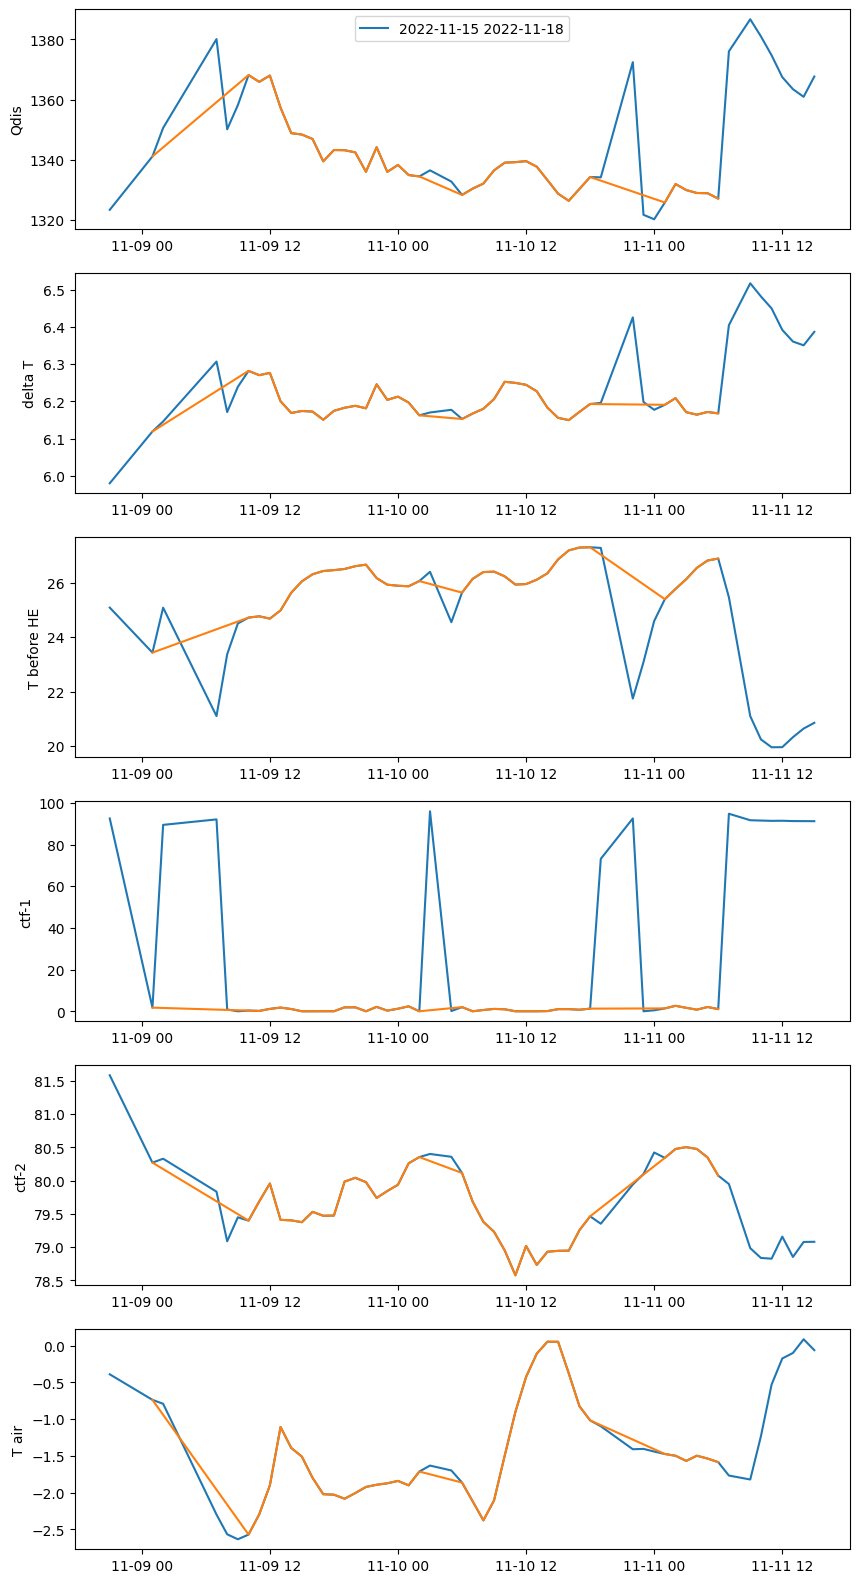

In [87]:
# lets observe changes after ctf1 filtering
# comparison tp2 before and after ctf1 (2 hours) filtering

fig, axs = plt.subplots(6,1, figsize=(10,20))
st = 0

df_tp2_before_cft1 = list(df_tps.values())[1]
df_tp2_after_cft1 = list(df_tps_fd_ctf1_1.values())[1]

X = np.arange(0+st, len(df_tp2_before_cft1) + st, 1)
X_init = np.arange(0+st, len(df_tp2_after_cft1) + st, 1)

# fig.suptitle("2022-11-08 - 2022-11-11")

axs[0].plot(df_tp2_before_cft1["Qdis"], label=k)
axs[0].plot(df_tp2_after_cft1["Qdis"])
axs[0].set_ylabel("Qdis")
axs[0].legend()

axs[1].plot(df_tp2_before_cft1[319] - df_tp2_before_cft1[317], label=k)
axs[1].plot(df_tp2_after_cft1[319] - df_tp2_after_cft1[317], label=k)
axs[1].set_ylabel("delta T")

axs[2].plot(df_tp2_before_cft1[317], label=k)
axs[2].plot(df_tp2_after_cft1[317], label=k)
axs[2].set_ylabel("T before HE")

axs[3].plot(df_tp2_before_cft1[381], label=k)
axs[3].plot(df_tp2_after_cft1[381], label=k)
axs[3].set_ylabel("ctf-1")

axs[4].plot(df_tp2_before_cft1[395], label=k)
axs[4].plot(df_tp2_after_cft1[395], label=k)
axs[4].set_ylabel("ctf-2")

axs[5].plot(df_tp2_before_cft1[327], label=k)
axs[5].plot(df_tp2_after_cft1[327], label=k)
axs[5].set_ylabel("T air")
    
#     st += len(v)
# initial_tp2

## The results are pretty well
## However the criteria of filtering is chosen manually
## How to tell to code when to drop data refers to ctf under operation and when not?
### Find peaks on @T before HE@ plot and Reflect determined peaks to other plots


[ 2  7 17 23 28 37 47]
[ 4 11 16 30 43]


['2022-11-08 2022-11-11', '2022-11-15 2022-11-18']

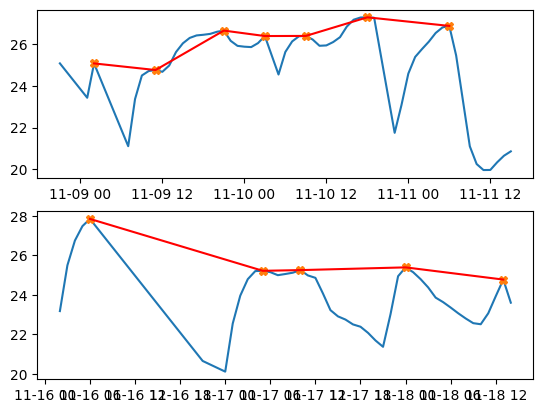

In [88]:
# apply find peaks to < T before HE > of initial dfs
# Taking only tps23
peaks23 = dict()
fig, axs = plt.subplots(2,1)

for n,i in enumerate(tps23):
    peaks23[i], _ = find_peaks(df_tps[i][317])
    print(peaks23[i])
    axs[n].plot(df_tps[i][317])
    axs[n].plot(np.array(df_tps[i].index)[peaks23[i]], df_tps[i][317][peaks23[i]], "X")
    axs[n].plot(np.array(df_tps[i].index)[peaks23[i]], df_tps[i][317][peaks23[i]], color="red")
#     print(np.array(df_tps[i].index))
tps23

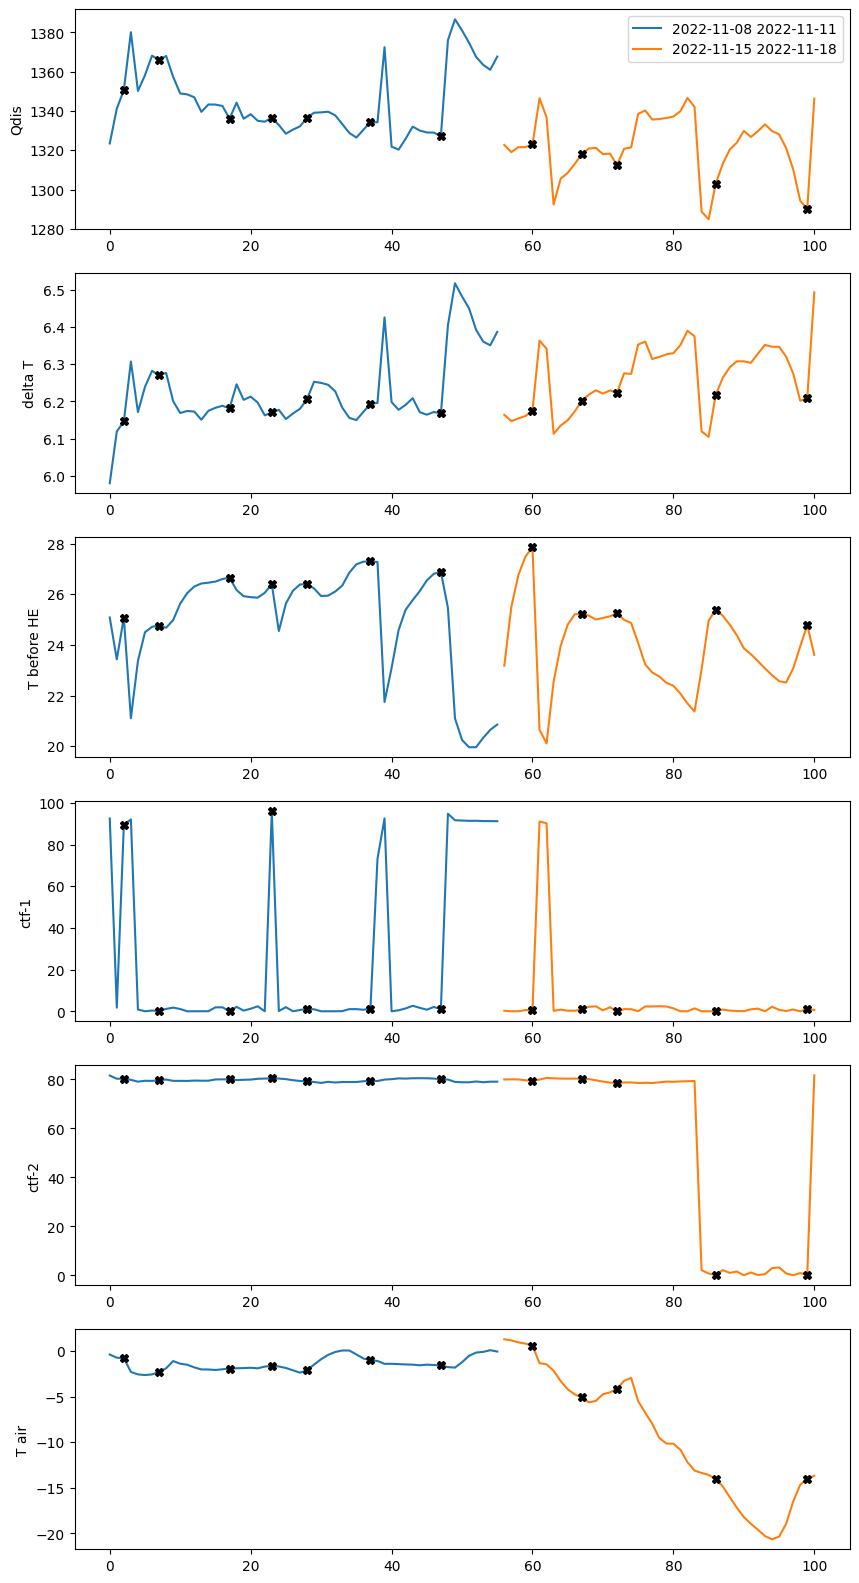

In [89]:
# apply < T before HE > peaks filtering on all parameters of tps23
# looks interesting. The average for each parameter is almost equal for this 2 weeks
fig, axs = plt.subplots(6,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps.items())[1:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].plot(X[peaks23[k]], v["Qdis"][peaks23[k]], "X", color="black")
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(X, v[319] - v[317], label=k)
    axs[1].plot(X[peaks23[k]], v[319][peaks23[k]] - v[317][peaks23[k]], "X", color="black")
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(X, v[317], label=k)
    axs[2].plot(X[peaks23[k]], v[317][peaks23[k]], "X", color="black")
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(X, v[381], label=k)
    axs[3].plot(X[peaks23[k]], v[381][peaks23[k]], "X", color="black")
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(X, v[395], label=k)
    axs[4].plot(X[peaks23[k]], v[395][peaks23[k]], "X", color="black")
    axs[4].set_ylabel("ctf-2")
    
    axs[5].plot(X, v[327], label=k)
    axs[5].plot(X[peaks23[k]], v[327][peaks23[k]], "X", color="black")
    axs[5].set_ylabel("T air")
    
    st += len(v)

In [90]:
tps1_3 = list(df_tps.keys())[0:3]
peaks1_3 = dict()
peaks1_3_prominance = dict()

for i in tps1_3:
    peaks1_3[i], _ = find_peaks(df_tps[i][317], distance=2, prominence=0.5)
    peaks1_3_prominance[i] = peak_prominences(df_tps[i][317], peaks1_3[i])
peaks1_3_prominance

{'2022-10-17 2022-10-21': (array([1.43711615, 1.11357443, 1.0804586 , 1.13924313, 1.43274768,
         1.01372559]),
  array([ 6, 37, 49, 60, 60, 89]),
  array([60, 60, 60, 76, 96, 96])),
 '2022-11-08 2022-11-11': (array([1.64885451, 2.1093811 , 0.53052647, 6.18911912, 5.13400283]),
  array([ 1,  3, 21,  3, 39]),
  array([ 3, 24, 24, 51, 51])),
 '2022-11-15 2022-11-18': (array([4.67187271, 3.88719819, 2.88219519, 1.17139464]),
  array([ 0,  6,  6, 40]),
  array([ 6, 27, 40, 44]))}

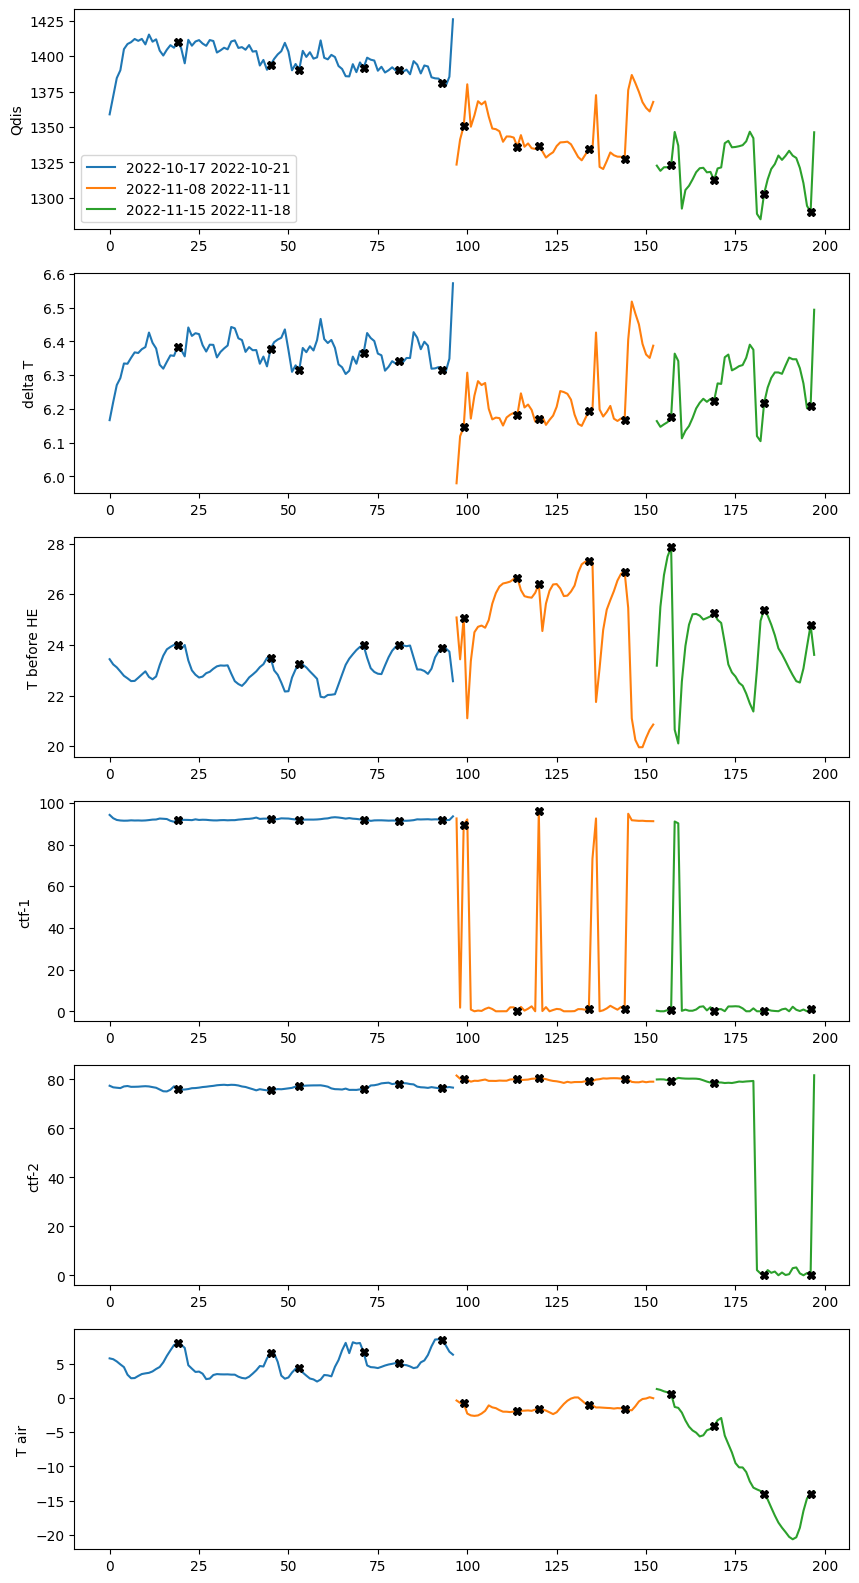

In [91]:
# apply < T before HE > peaks filtering on all parameters of tps1_3
# looks interesting. The average for each parameter is almost equal for this 3 weeks
fig, axs = plt.subplots(6,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps.items())[0:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].plot(X[peaks1_3[k]], v["Qdis"][peaks1_3[k]], "X", color="black")
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(X, v[319] - v[317], label=k)
    axs[1].plot(X[peaks1_3[k]], v[319][peaks1_3[k]] - v[317][peaks1_3[k]], "X", color="black")
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(X, v[317], label=k)
    axs[2].plot(X[peaks1_3[k]], v[317][peaks1_3[k]], "X", color="black")
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(X, v[381], label=k)
    axs[3].plot(X[peaks1_3[k]], v[381][peaks1_3[k]], "X", color="black")
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(X, v[395], label=k)
    axs[4].plot(X[peaks1_3[k]], v[395][peaks1_3[k]], "X", color="black")
    axs[4].set_ylabel("ctf-2")
    
    axs[5].plot(X, v[327], label=k)
    axs[5].plot(X[peaks1_3[k]], v[327][peaks1_3[k]], "X", color="black")
    axs[5].set_ylabel("T air")
    
    st += len(v)

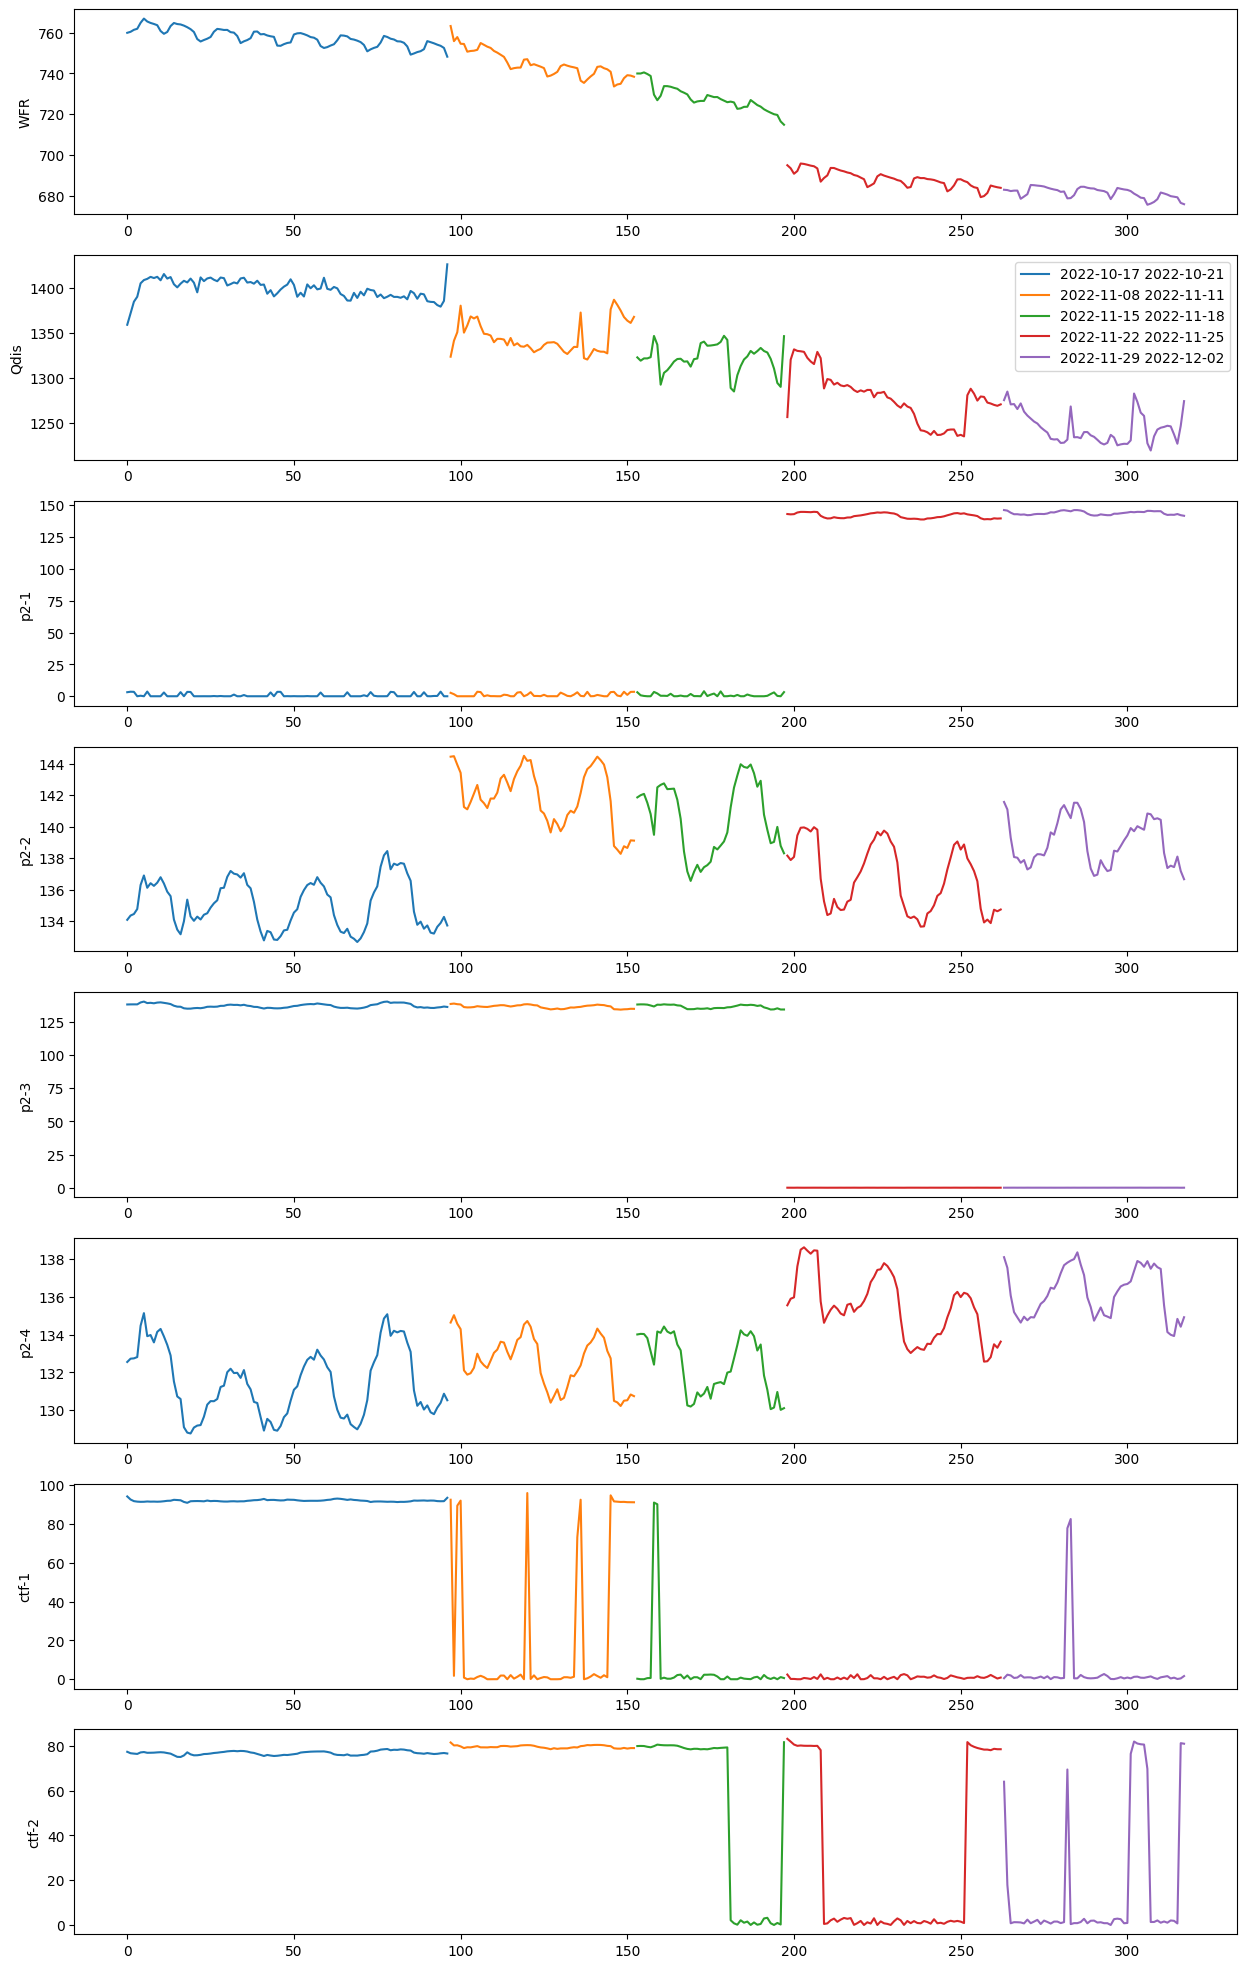

In [92]:
# lets extend out dataset up to 5 weeks

fig, axs = plt.subplots(8,1, figsize=(15,25))
st = 0

# take only 4 first periods
for k, v in list(df_tps.items())[:5]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v[481], label=k)
    axs[0].set_ylabel("WFR")
    
    axs[1].plot(X, v["Qdis"], label=k)
    axs[1].set_ylabel("Qdis")
    axs[1].legend()
    
    axs[2].plot(X, v[406], label=k)
    axs[2].set_ylabel("p2-1")
    
    axs[3].plot(X, v[407], label=k)
    axs[3].set_ylabel("p2-2")

    axs[4].plot(X, v[408], label=k)
    axs[4].set_ylabel("p2-3")
    
    axs[5].plot(X, v[409], label=k)
    axs[5].set_ylabel("p2-4")
    
    axs[6].plot(X, v[381], label=k)
    axs[6].set_ylabel("ctf-1")
    
    axs[7].plot(X, v[395], label=k)
    axs[7].set_ylabel("ctf-2")
    
    st += len(v)

In [93]:
# lets extend out dataset up to 4 weeks
tps1_4 = list(df_tps.keys())[:4]
peaks1_4 = dict()

for i in tps1_4:
    peaks1_4[i], _ = find_peaks(df_tps[i][317], distance=1)

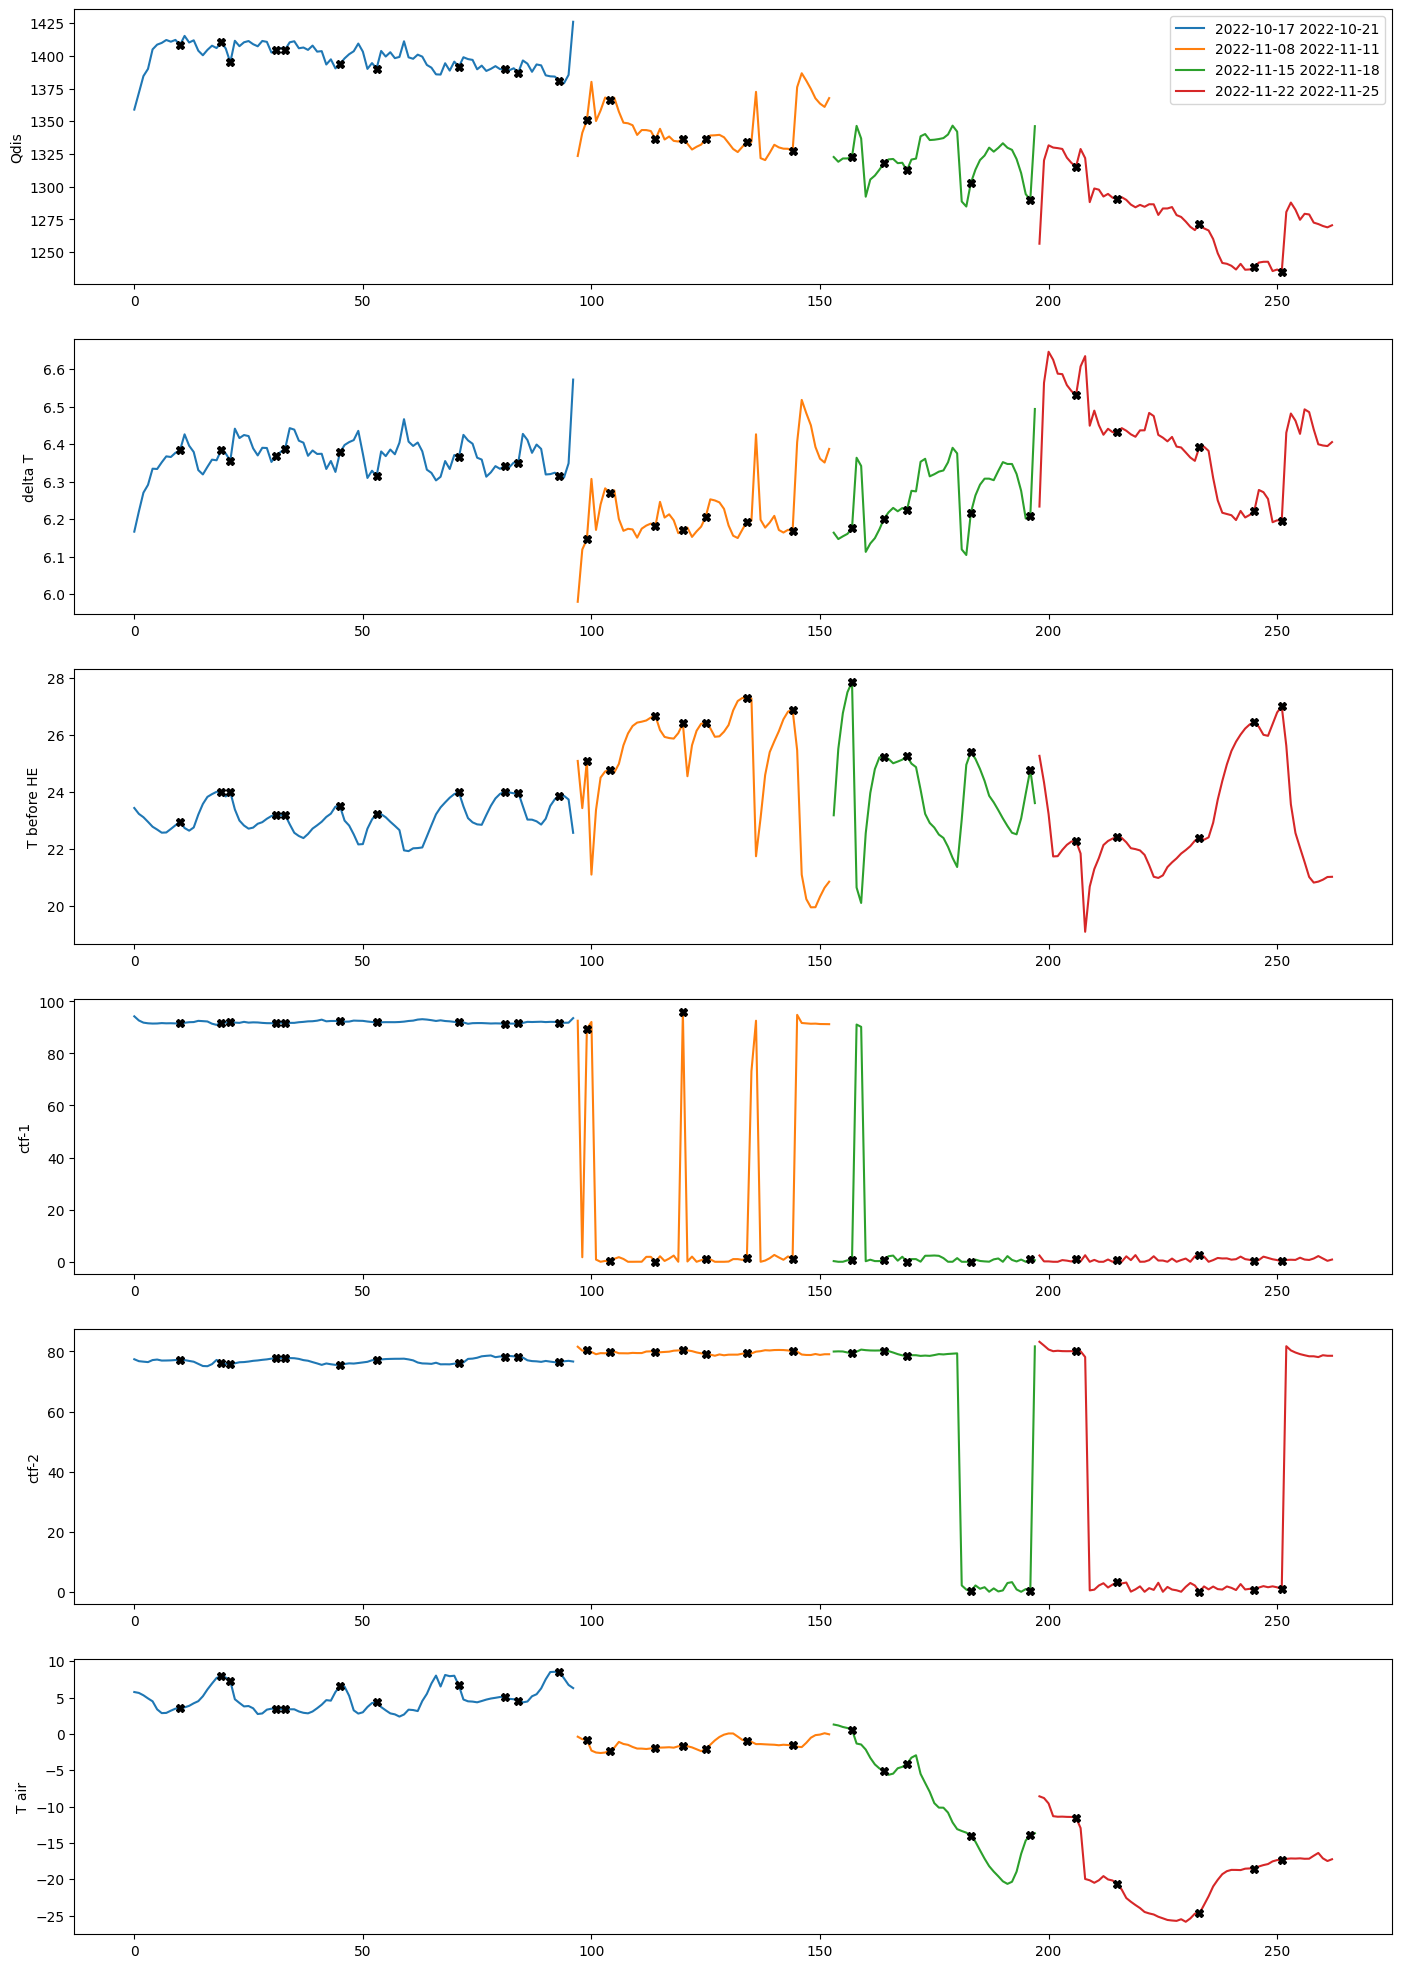

In [94]:
# lets extend out dataset up to 4 weeks
fig, axs = plt.subplots(6,1, figsize=(17,25))
st = 0

# take only 4 first periods
for k, v in list(df_tps.items())[:4]:
    X = np.arange(0+st, len(v) + st, 1)
    
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].plot(X[peaks1_4[k]], v["Qdis"][peaks1_4[k]], "X", color="black")
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(X, v[319] - v[317], label=k)
    axs[1].plot(X[peaks1_4[k]], v[319][peaks1_4[k]] - v[317][peaks1_4[k]], "X", color="black")
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(X, v[317], label=k)
    axs[2].plot(X[peaks1_4[k]], v[317][peaks1_4[k]], "X", color="black")
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(X, v[381], label=k)
    axs[3].plot(X[peaks1_4[k]], v[381][peaks1_4[k]], "X", color="black")
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(X, v[395], label=k)
    axs[4].plot(X[peaks1_4[k]], v[395][peaks1_4[k]], "X", color="black")
    axs[4].set_ylabel("ctf-2")
    
    axs[5].plot(X, v[327], label=k)
    axs[5].plot(X[peaks1_4[k]], v[327][peaks1_4[k]], "X", color="black")
    axs[5].set_ylabel("T air")
    
    st += len(v)

In [95]:
# lets observe dataset from 5 to 8 weeks
tps5_8 = list(df_tps.keys())[4:]
peaks5_8 = dict()

for i in tps5_8:
    peaks5_8[i], _ = find_peaks(df_tps[i][317], distance=1)

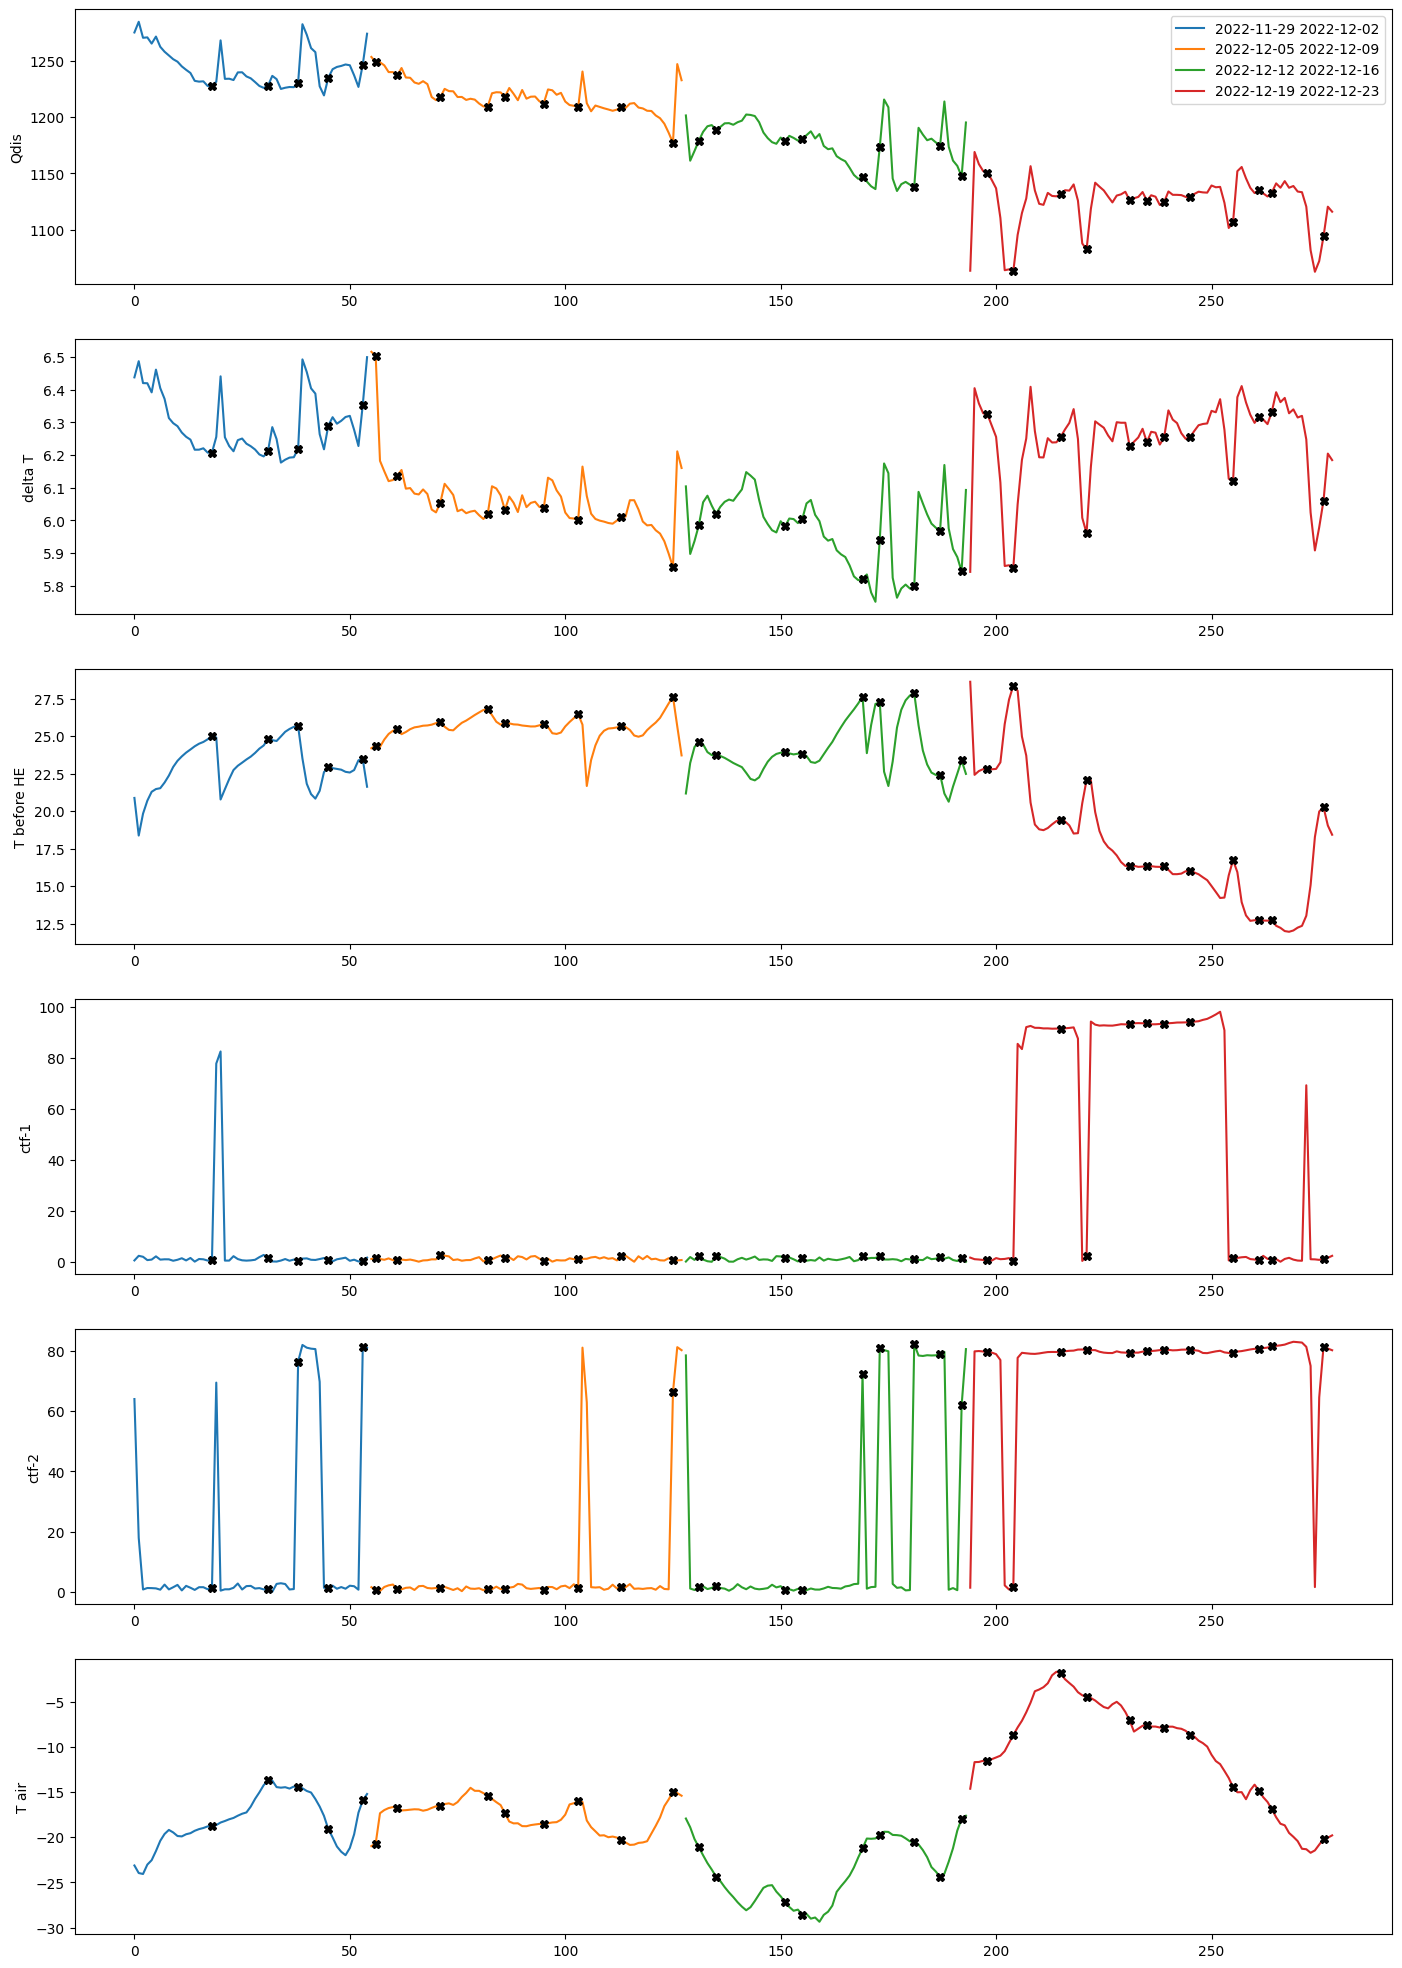

In [96]:
# lets observe dataset from 5 to 8 weeks
fig, axs = plt.subplots(6,1, figsize=(17,25))
st = 0

# take only 4 first periods
for k, v in list(df_tps.items())[4:]:
    X = np.arange(0+st, len(v) + st, 1)
    
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].plot(X[peaks5_8[k]], v["Qdis"][peaks5_8[k]], "X", color="black")
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(X, v[319] - v[317], label=k)
    axs[1].plot(X[peaks5_8[k]], v[319][peaks5_8[k]] - v[317][peaks5_8[k]], "X", color="black")
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(X, v[317], label=k)
    axs[2].plot(X[peaks5_8[k]], v[317][peaks5_8[k]], "X", color="black")
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(X, v[381], label=k)
    axs[3].plot(X[peaks5_8[k]], v[381][peaks5_8[k]], "X", color="black")
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(X, v[395], label=k)
    axs[4].plot(X[peaks5_8[k]], v[395][peaks5_8[k]], "X", color="black")
    axs[4].set_ylabel("ctf-2")
    
    axs[5].plot(X, v[327], label=k)
    axs[5].plot(X[peaks5_8[k]], v[327][peaks5_8[k]], "X", color="black")
    axs[5].set_ylabel("T air")
    
    st += len(v)

In [97]:
# converts ctfs data into categorical data (0 and 1)
df_tps_ctf_cat = df_tps.copy()
for i in tps:
    df_tps_ctf_cat[i]["381_c"] = np.where(df_tps_ctf_cat[i][381] > 5.0, 1, 0)
    df_tps_ctf_cat[i]["395_c"] = np.where(df_tps_ctf_cat[i][395] > 5.0, 1, 0)
#     print(df_tps[i][381_0])

In [98]:
# lets find also negative peaks of our dataset up to 4 weeks
peaks1_4_neg = dict()

for i in tps1_4:
    peaks1_4_neg[i], _ = find_peaks(-df_tps_ctf_cat[i][317], distance=1)

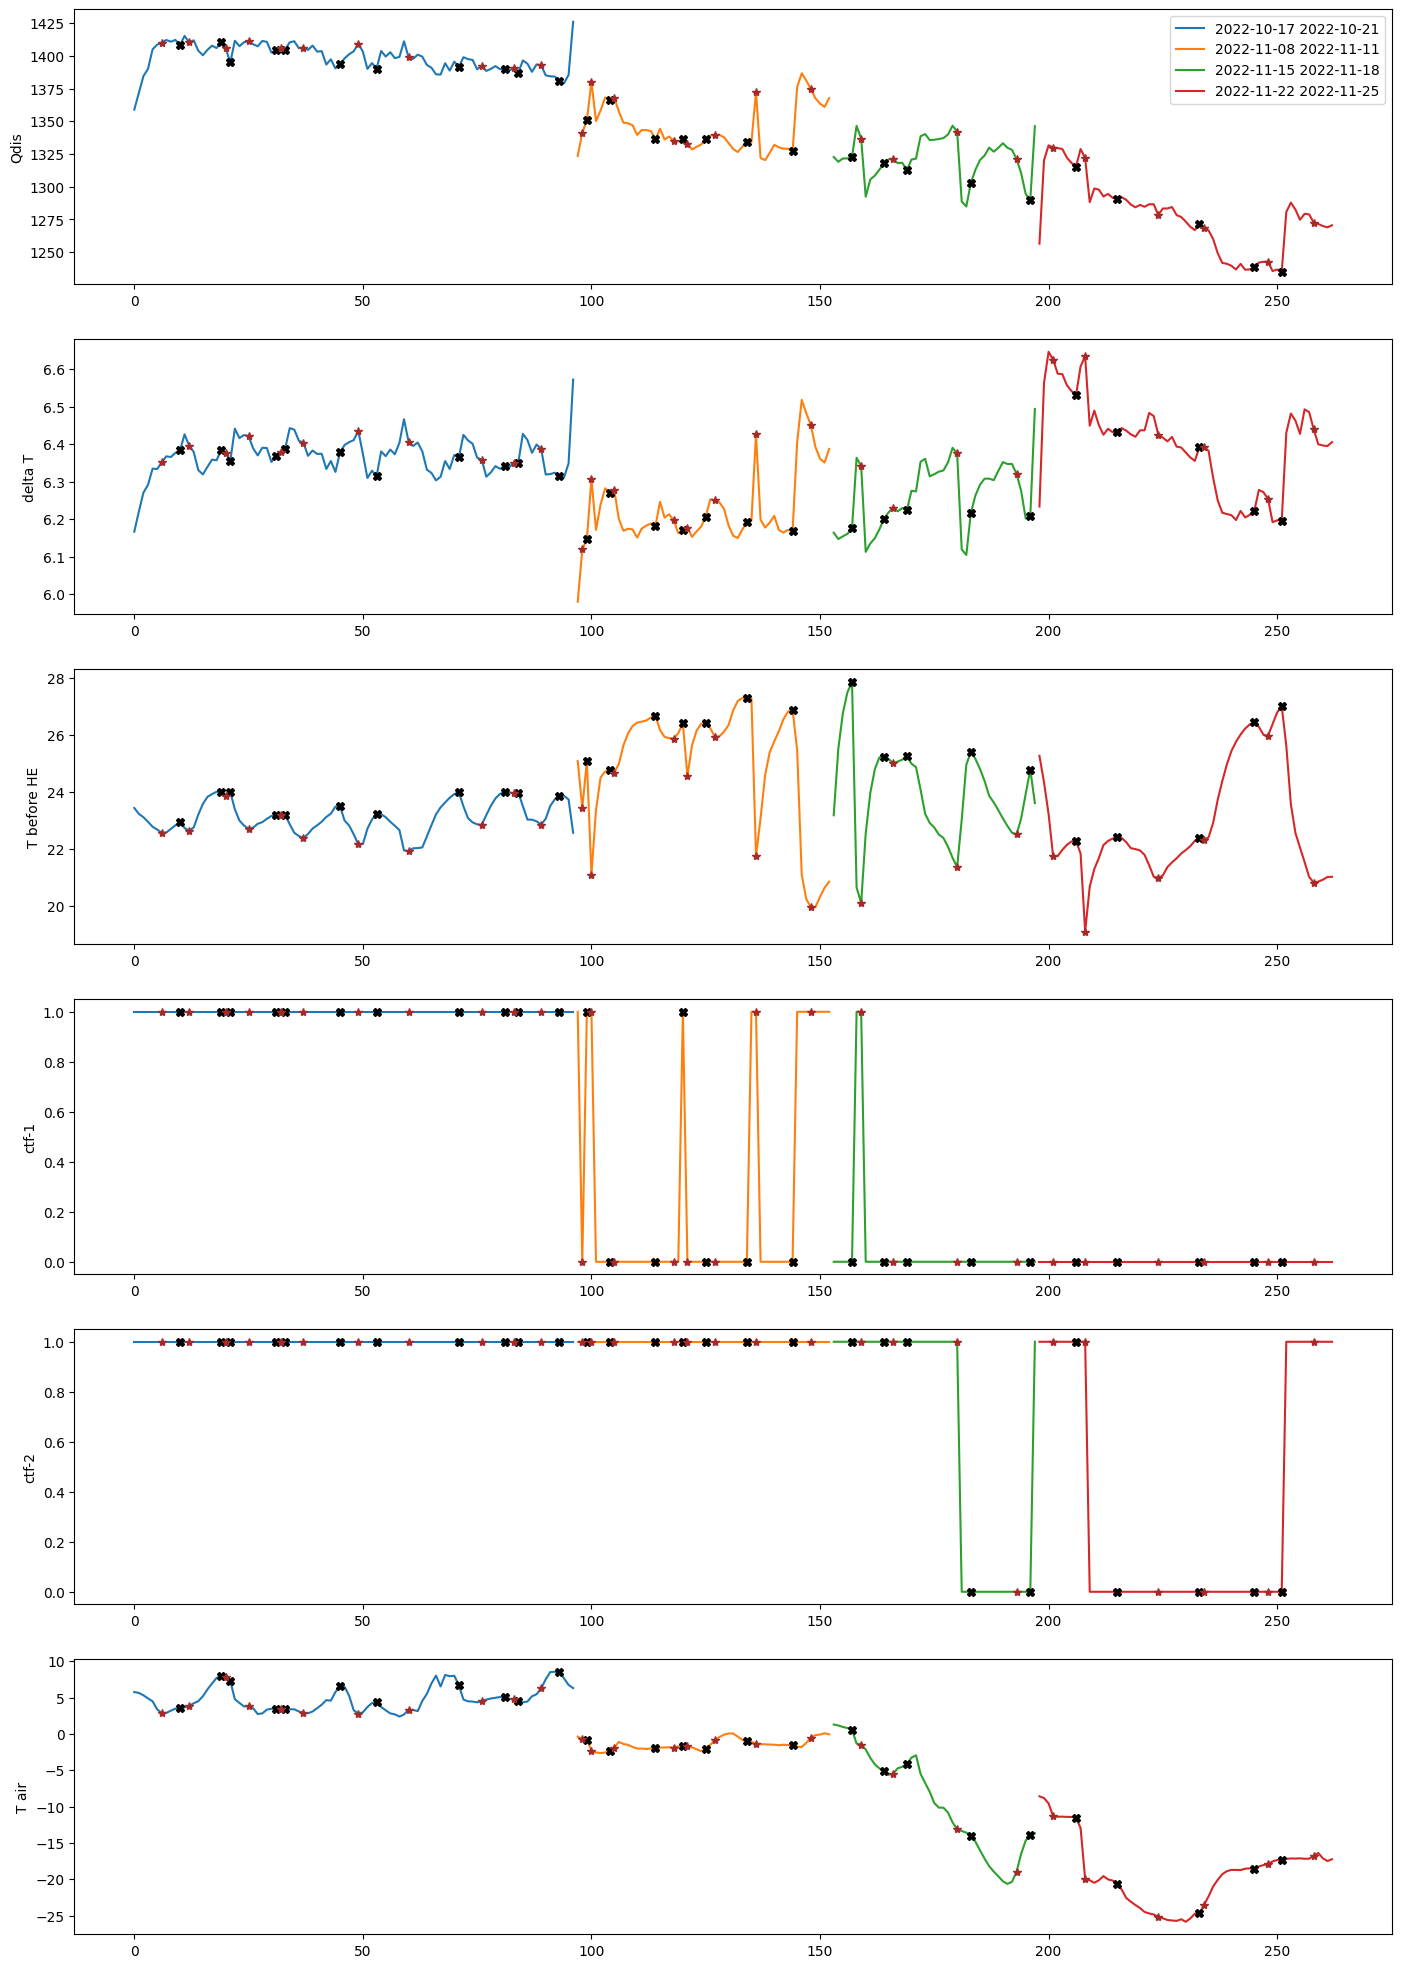

In [99]:

fig, axs = plt.subplots(6,1, figsize=(17,25))
st = 0

# take only 4 first periods
for k, v in list(df_tps_ctf_cat.items())[:4]:
    X = np.arange(0+st, len(v) + st, 1)
    
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].plot(X[peaks1_4[k]], v["Qdis"][peaks1_4[k]], "X", color="black")
    axs[0].plot(X[peaks1_4_neg[k]], v["Qdis"][peaks1_4_neg[k]], "*", color="brown")
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(X, v[319] - v[317], label=k)
    axs[1].plot(X[peaks1_4[k]], v[319][peaks1_4[k]] - v[317][peaks1_4[k]], "X", color="black")
    axs[1].plot(X[peaks1_4_neg[k]], v[319][peaks1_4_neg[k]] - v[317][peaks1_4_neg[k]], "*", color="brown")
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(X, v[317], label=k)
    axs[2].plot(X[peaks1_4[k]], v[317][peaks1_4[k]], "X", color="black")
    axs[2].plot(X[peaks1_4_neg[k]], v[317][peaks1_4_neg[k]], "*", color="brown")
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(X, v["381_c"], label=k)
    axs[3].plot(X[peaks1_4[k]], v["381_c"][peaks1_4[k]], "X", color="black")
    axs[3].plot(X[peaks1_4_neg[k]], v["381_c"][peaks1_4_neg[k]], "*", color="brown")
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(X, v["395_c"], label=k)
    axs[4].plot(X[peaks1_4[k]], v["395_c"][peaks1_4[k]], "X", color="black")
    axs[4].plot(X[peaks1_4_neg[k]], v["395_c"][peaks1_4_neg[k]], "*", color="brown")
    axs[4].set_ylabel("ctf-2")
    
    axs[5].plot(X, v[327], label=k)
    axs[5].plot(X[peaks1_4[k]], v[327][peaks1_4[k]], "X", color="black")
    axs[5].plot(X[peaks1_4_neg[k]], v[327][peaks1_4_neg[k]], "*", color="brown")
    axs[5].set_ylabel("T air")
    
    st += len(v)

In [100]:
# lets negative peaks of our dataset from 5 to 8 weeks
peaks5_8_neg = dict()

for i in tps5_8:
    peaks5_8_neg[i], _ = find_peaks(-df_tps_ctf_cat[i][317], distance=1)

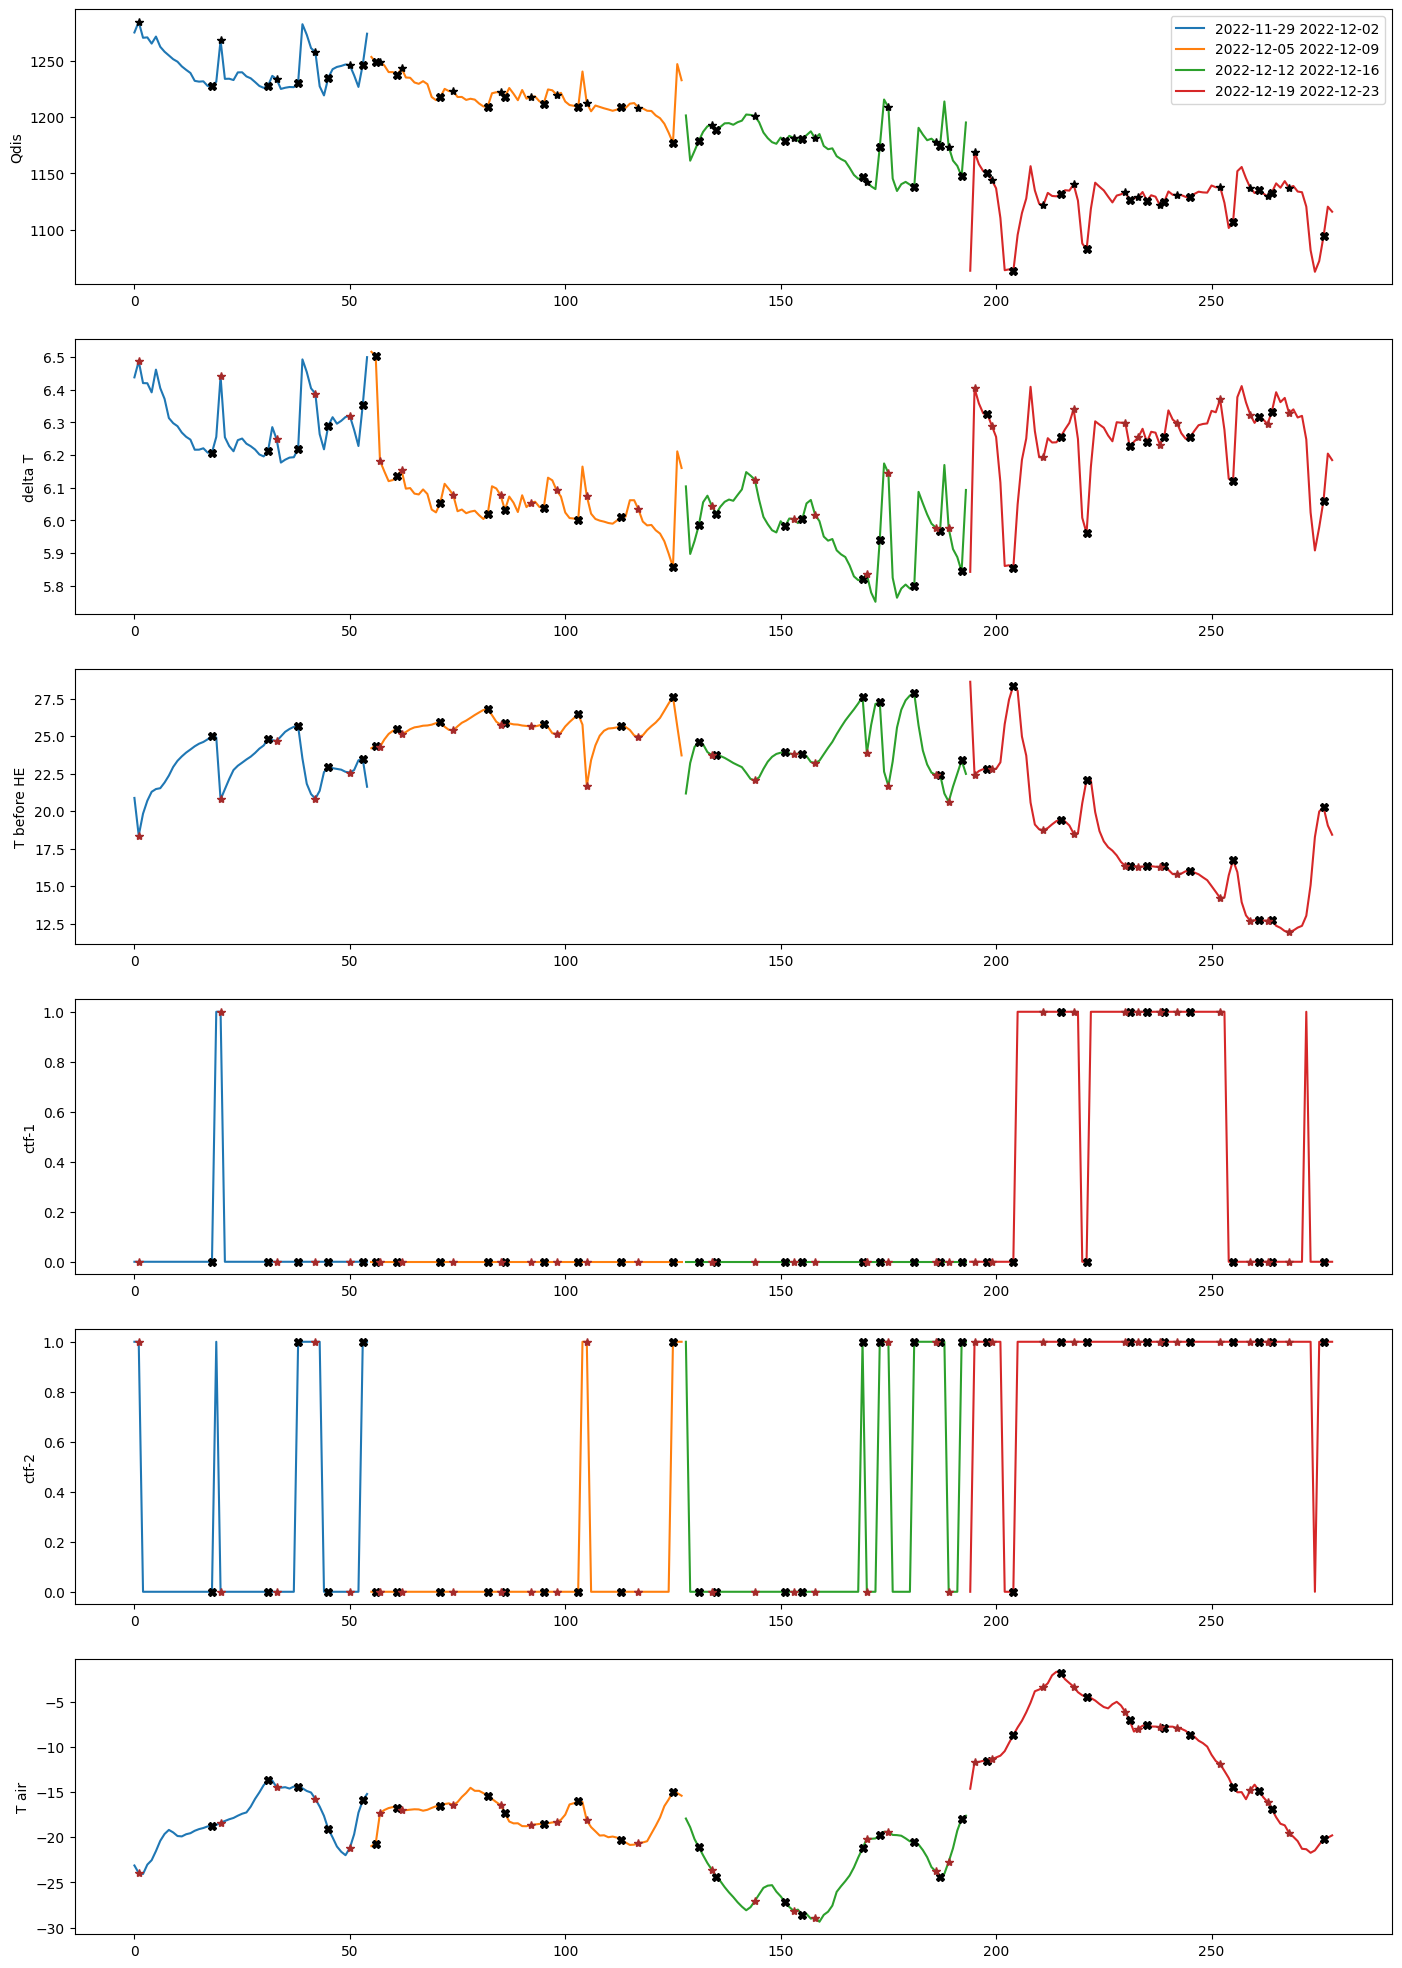

In [101]:

fig, axs = plt.subplots(6,1, figsize=(17,25))
st = 0

# take only 4 first periods
for k, v in list(df_tps_ctf_cat.items())[4:]:
    X = np.arange(0+st, len(v) + st, 1)
    
    axs[0].plot(X, v["Qdis"], label=k)
    axs[0].plot(X[peaks5_8[k]], v["Qdis"][peaks5_8[k]], "X", color="black")
    axs[0].plot(X[peaks5_8_neg[k]], v["Qdis"][peaks5_8_neg[k]], "*", color="black")
    axs[0].set_ylabel("Qdis")
    axs[0].legend()
    
    axs[1].plot(X, v[319] - v[317], label=k)
    axs[1].plot(X[peaks5_8[k]], v[319][peaks5_8[k]] - v[317][peaks5_8[k]], "X", color="black")
    axs[1].plot(X[peaks5_8_neg[k]], v[319][peaks5_8_neg[k]] - v[317][peaks5_8_neg[k]], "*", color="brown")
    axs[1].set_ylabel("delta T")
    
    axs[2].plot(X, v[317], label=k)
    axs[2].plot(X[peaks5_8[k]], v[317][peaks5_8[k]], "X", color="black")
    axs[2].plot(X[peaks5_8_neg[k]], v[317][peaks5_8_neg[k]], "*", color="brown")
    axs[2].set_ylabel("T before HE")
    
    axs[3].plot(X, v["381_c"], label=k)
    axs[3].plot(X[peaks5_8[k]], v["381_c"][peaks5_8[k]], "X", color="black")
    axs[3].plot(X[peaks5_8_neg[k]], v["381_c"][peaks5_8_neg[k]], "*", color="brown")
    axs[3].set_ylabel("ctf-1")
    
    axs[4].plot(X, v["395_c"], label=k)
    axs[4].plot(X[peaks5_8[k]], v["395_c"][peaks5_8[k]], "X", color="black")
    axs[4].plot(X[peaks5_8_neg[k]], v["395_c"][peaks5_8_neg[k]], "*", color="brown")
    axs[4].set_ylabel("ctf-2")
    
    axs[5].plot(X, v[327], label=k)
    axs[5].plot(X[peaks5_8[k]], v[327][peaks5_8[k]], "X", color="black")
    axs[5].plot(X[peaks5_8_neg[k]], v[327][peaks5_8_neg[k]], "*", color="brown")
    axs[5].set_ylabel("T air")
    
    st += len(v)

In [102]:
df_tps_merged = pd.DataFrame()
for i in tps:
    df_tps_merged = pd.concat([df_tps_merged, df_tps_ctf_cat[i]], axis=0)
df_tps_merged

309        317        319        325        327  \
Timestamp                                                               
2022-10-17 18:00:00  0.45  23.436021  29.602674  29.117838   5.754091   
2022-10-17 19:00:00  0.45  23.230688  29.451052  28.993011   5.632039   
2022-10-17 20:00:00  0.45  23.113757  29.384408  28.931720   5.305963   
2022-10-17 21:00:00  0.45  22.951052  29.242487  28.786559   4.877073   
2022-10-17 22:00:00  0.45  22.781081  29.115676  28.628192   4.478302   
...                   ...        ...        ...        ...        ...   
2022-12-23 10:00:00  0.42  18.283838  24.191626  24.107426 -21.457674   
2022-12-23 11:00:00  0.42  19.979897  25.958673  25.834536 -20.816818   
2022-12-23 12:00:00  0.42  20.275000  26.335567  26.190863 -20.190611   
2022-12-23 13:00:00  0.42  19.046907  25.251282  25.104188 -20.048624   
2022-12-23 14:00:00  0.42  18.431579  24.616043  24.479487 -19.793518   

                            481        315        299         Qdis  \
Timestamp                                                            
2022-10-17 18:00:00  759.866667  47.252380  40.242391  1358.891821   
2022-10-17 19:00:00  760.366667  47.276503  40.235829  1371.629728   
2022-10-17 20:00:00  761.337500  47.408153  40.283871  1384.483736   
2022-10-17 21:00:00  761.841667  47.365406  40.201106  1389.992362   
2022-10-17 22:00:00  764.762500  47.346237  40.154255  1404.893673   
...                         ...        ...        ...          ...   
2022-12-23 10:00:00  620.266667  40.439500  34.183756  1062.677015   
2022-12-23 11:00:00  618.400000  42.153926  35.885417  1072.209876   
2022-12-23 12:00:00  622.500000  42.724599  36.390526  1094.083848   
2022-12-23 13:00:00  622.750000  42.074211  35.633333  1120.494584   
2022-12-23 14:00:00  622.266667  41.428342  34.993048  1116.031909   

                           WFR1  ...         406         407         408  \
Timestamp                        ...                                       
2022-10-17 18:00:00  206.176740  ...    3.167945  134.084178  137.817544   
2022-10-17 19:00:00  205.201878  ...    3.550354  134.356837  137.882519   
2022-10-17 20:00:00  205.144040  ...    3.457131  134.453806  137.902331   
2022-10-17 21:00:00  205.341103  ...    0.000000  134.770786  137.892265   
2022-10-17 22:00:00  207.130530  ...    0.413961  136.292825  139.339687   
...                         ...  ...         ...         ...         ...   
2022-12-23 10:00:00  157.308685  ...  135.087512  136.702570    0.325915   
2022-12-23 11:00:00  157.878020  ...  134.921923  136.503508    0.300109   
2022-12-23 12:00:00  159.431640  ...  135.323383  136.903886    0.310014   
2022-12-23 13:00:00  159.468178  ...  134.023059  135.632650    0.315827   
2022-12-23 14:00:00  159.079208  ...  134.327193  135.959059    0.325197   

                            409        460        461        462        463  \
Timestamp                                                                     
2022-10-17 18:00:00  132.553080  29.283641  30.993832  29.848918  20.693617   
2022-10-17 19:00:00  132.728396  29.123370  30.842234  29.688948  20.962333   
2022-10-17 20:00:00  132.744871  29.058882  30.797057  29.625277  21.254337   
2022-10-17 21:00:00  132.813463  28.917116  30.668369  29.480841  21.563265   
2022-10-17 22:00:00  134.472179  28.763071  30.528097  29.332079  21.887931   
...                         ...        ...        ...        ...        ...   
2022-12-23 10:00:00  136.779838  24.058267  25.623620  24.162952  28.960615   
2022-12-23 11:00:00  136.475204  25.771055  27.376859  25.895215  28.971942   
2022-12-23 12:00:00  137.006221  26.157992  27.787223  26.266199  29.005838   
2022-12-23 13:00:00  136.792348  25.083708  26.736515  25.169248  29.076666   
2022-12-23 14:00:00  137.047239  24.439001  26.095648  24.530568  29.145336   

                     381_c  395_c  
Timestamp                          
2022-10-17 18:00:00      1      1  
2022-10-17 19:00:00      1      1  


In [103]:
df_tps_merged.to_csv("df_171022_231222.csv")

In [104]:
import iapws

# applies for each HE to determine alpha
def alpha_determine(t, p1, D, dint):
    ia = iapws.IAPWS95(P = p1, T = t)
    #Кинематическая вязкость
    v = ia.nu # м2/с
    #Число Прандтля
    Pr = ia.Prandt
    #Теплопроводность материала труб
    lam = ia.k #Вт/(м*К)
    #Число Рейнольдса 
    Re = (D/3600)*dint/v
    #Число Нуссельта (пока непонятно как считывается)
    Nu = 0.023 * Re**0.8 * 5.43**0.3
    #Коэффициент теплоотдачи (пока непонятно как считывается)
    alpha = Nu*lam/(dint) #Вт/м*К
    return alpha

In [105]:
# add new column alpha to dfs
for df in df_tps.values():
#     print(df)
    df["alpha_in1"] = df.apply(lambda x: alpha_determine(x[317]+273.15, x[309], x["WFR1"], 17*10**-3), axis=1)
    df["alpha_in2"] = df.apply(lambda x: alpha_determine(x[317]+273.15, x[309], x["WFR2"], 17*10**-3), axis=1)
    df["alpha_in3"] = df.apply(lambda x: alpha_determine(x[317]+273.15, x[309], x["WFR3"], 17*10**-3), axis=1)
    df["alpha_in4"] = df.apply(lambda x: alpha_determine(x[317]+273.15, x[309], x["WFR4"], 17*10**-3), axis=1)
    df["alpha_out1"] = df.apply(lambda x: alpha_determine(x[325]+273.15, x[309], x["WFR1"], 17*10**-3), axis=1)
    df["alpha_out2"] = df.apply(lambda x: alpha_determine(x[460]+273.15, x[309], x["WFR2"], 17*10**-3), axis=1)
    df["alpha_out3"] = df.apply(lambda x: alpha_determine(x[461]+273.15, x[309], x["WFR3"], 17*10**-3), axis=1)
    df["alpha_out4"] = df.apply(lambda x: alpha_determine(x[462]+273.15, x[309], x["WFR4"], 17*10**-3), axis=1)
    df["alpha_1"] = (df["alpha_in1"]+ df["alpha_out1"])/2
    df["alpha_2"] = (df["alpha_in2"]+ df["alpha_out2"])/2
    df["alpha_3"] = (df["alpha_in3"]+ df["alpha_out3"])/2
    df["alpha_4"] = (df["alpha_in4"]+ df["alpha_out4"])/2

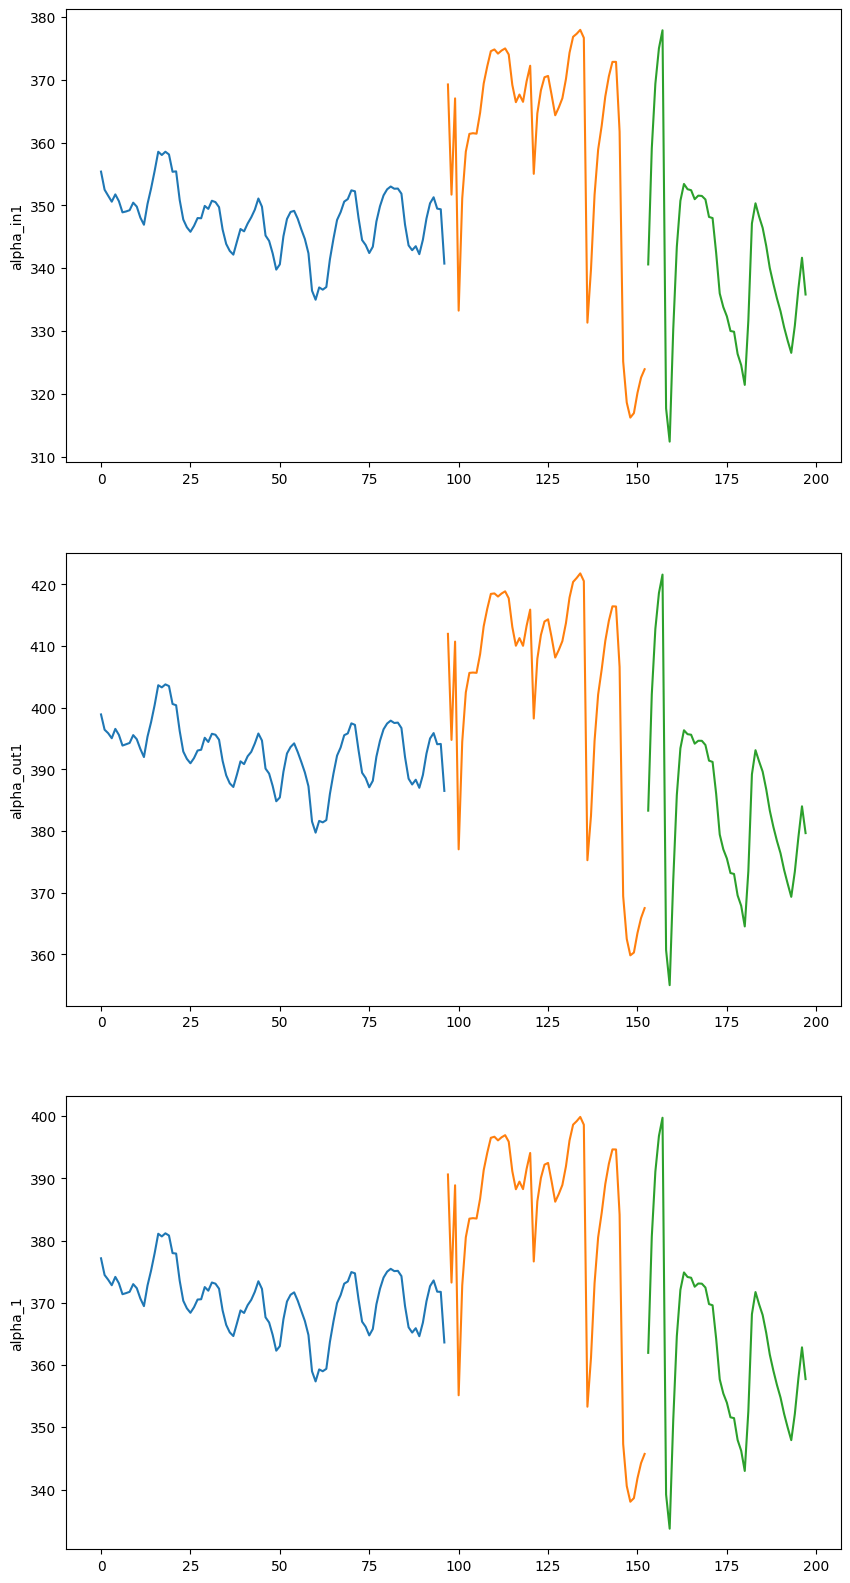

In [106]:
fig, axs = plt.subplots(3,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps.items())[:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["alpha_in1"], label=k)
    axs[0].set_ylabel("alpha_in1")
    
    axs[1].plot(X, v["alpha_out1"], label=k)
    axs[1].set_ylabel("alpha_out1")
    
    axs[2].plot(X, v["alpha_1"], label=k)
    axs[2].set_ylabel("alpha_1")
    
    
    st += len(v)

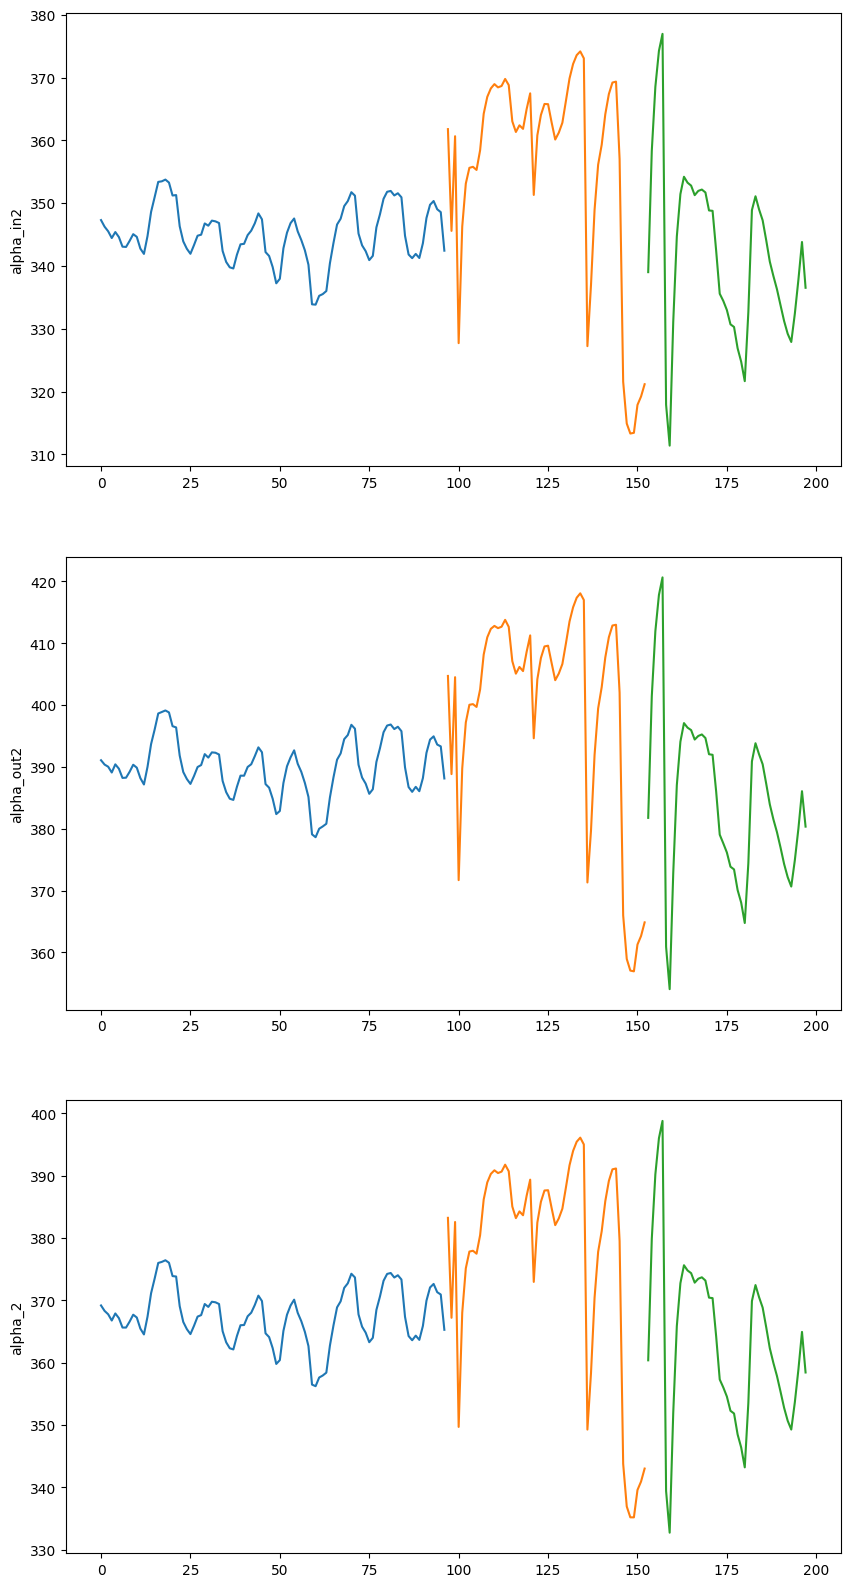

In [107]:
fig, axs = plt.subplots(3,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps.items())[:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["alpha_in2"], label=k)
    axs[0].set_ylabel("alpha_in2")
    
    axs[1].plot(X, v["alpha_out2"], label=k)
    axs[1].set_ylabel("alpha_out2")
    
    axs[2].plot(X, v["alpha_2"], label=k)
    axs[2].set_ylabel("alpha_2")
    
    
    st += len(v)

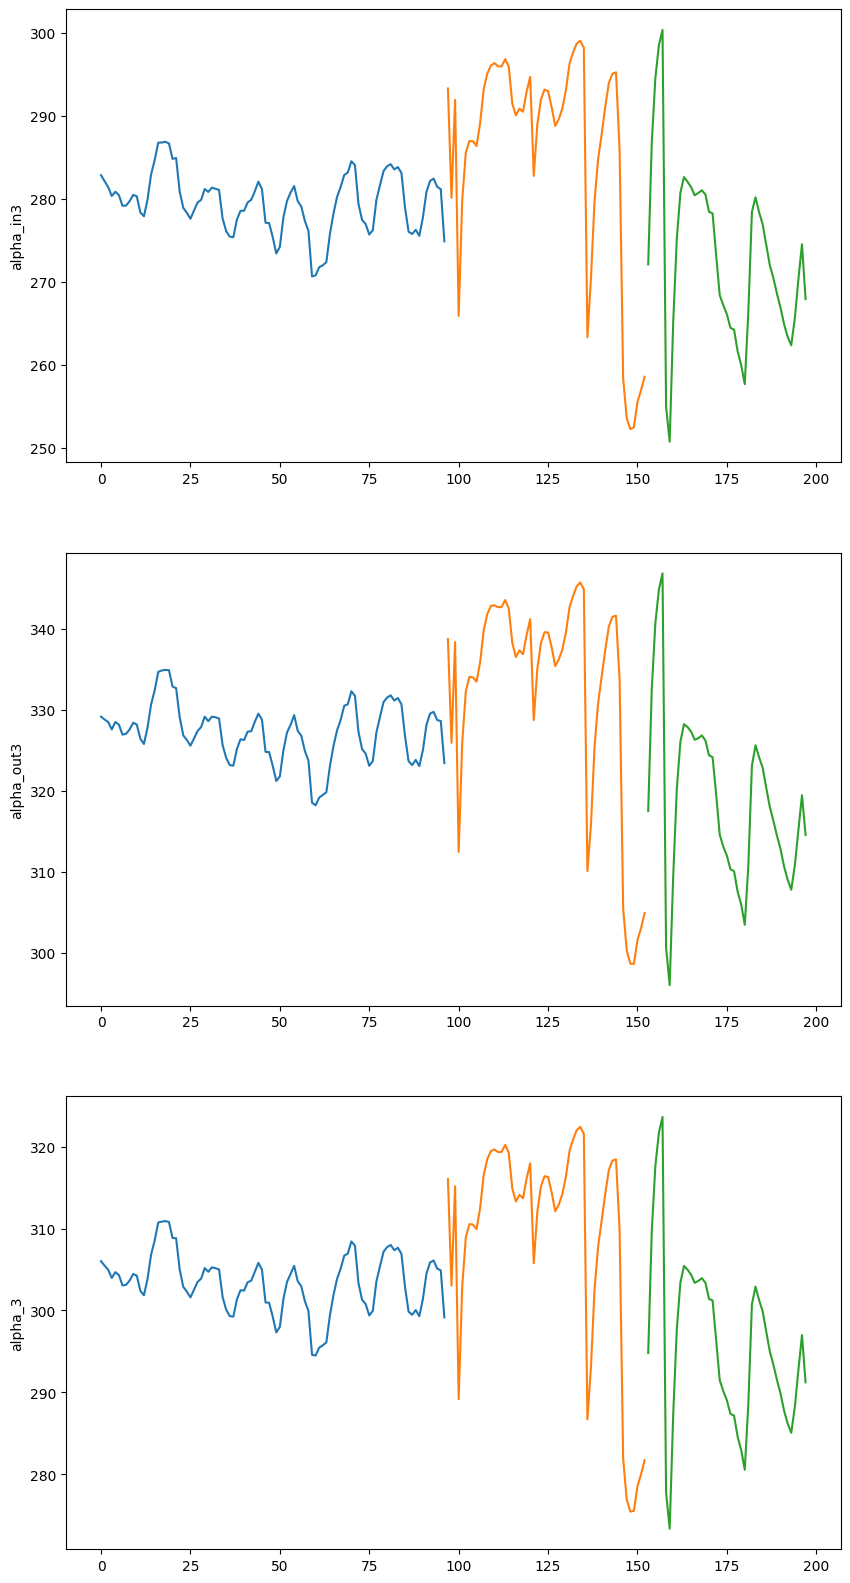

In [108]:
fig, axs = plt.subplots(3,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps.items())[:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["alpha_in3"], label=k)
    axs[0].set_ylabel("alpha_in3")
    
    axs[1].plot(X, v["alpha_out3"], label=k)
    axs[1].set_ylabel("alpha_out3")
    
    axs[2].plot(X, v["alpha_3"], label=k)
    axs[2].set_ylabel("alpha_3")
    
    
    st += len(v)

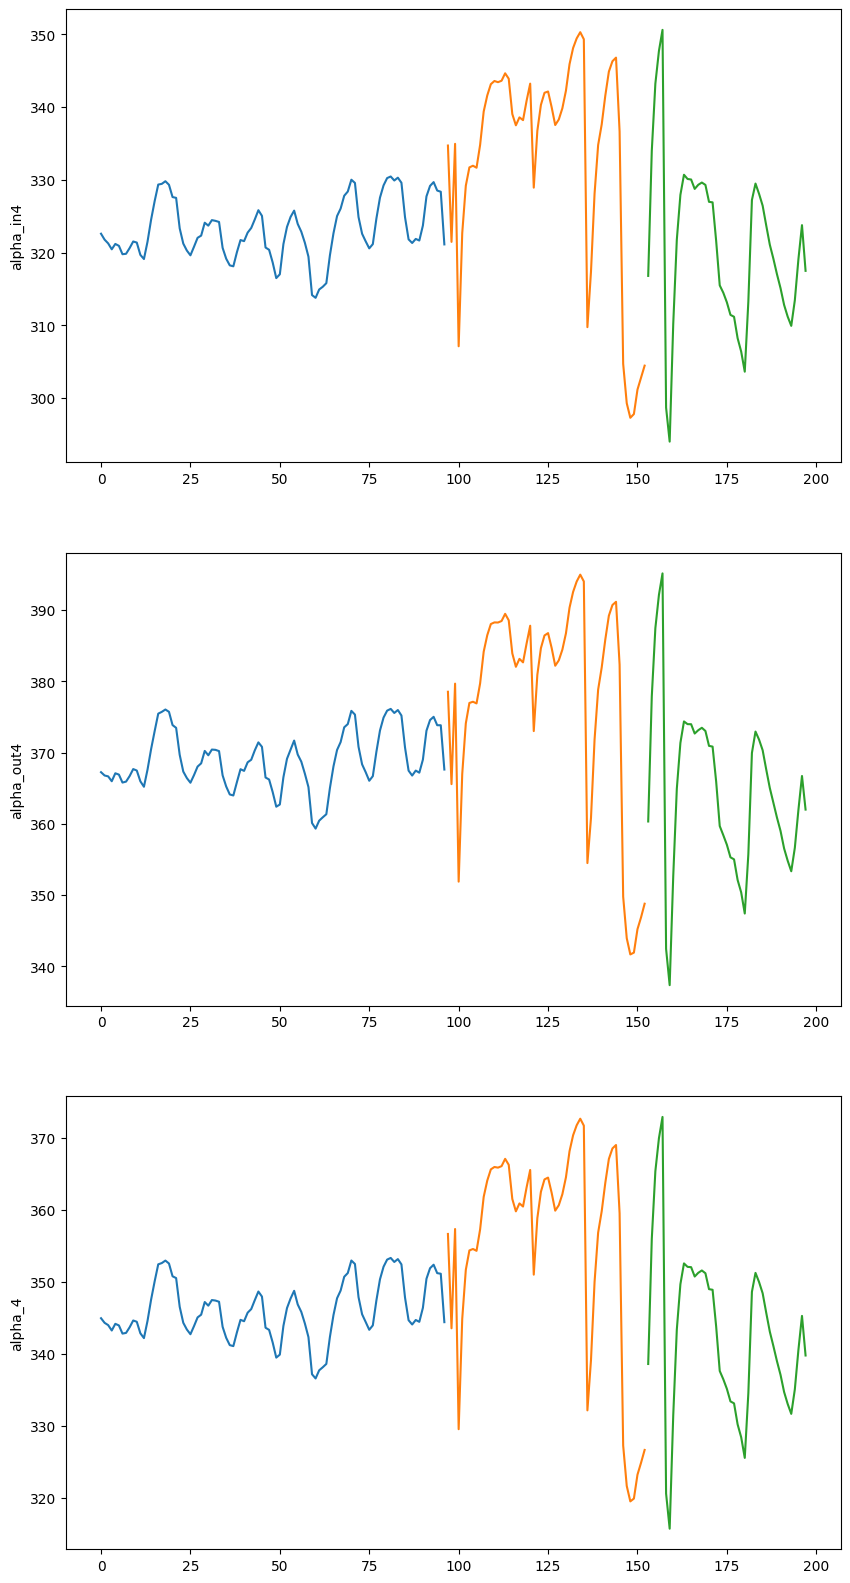

In [109]:
fig, axs = plt.subplots(3,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps.items())[:3]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["alpha_in4"], label=k)
    axs[0].set_ylabel("alpha_in4")
    
    axs[1].plot(X, v["alpha_out4"], label=k)
    axs[1].set_ylabel("alpha_out4")
    
    axs[2].plot(X, v["alpha_4"], label=k)
    axs[2].set_ylabel("alpha_4")
    
    
    st += len(v)

In [129]:
import math
def alpha_equation_determine(D, t1in, t1out, t2in, t2out, F):
    # D is voulemtric WFR for each HE, has to be transferred to mass flow rate
    # F is toatl useful area of HE
    # t1in, t1out the temperatures on the inlet and outlet collector of primary curccuit respecfully
    # t2in, t2out the temperatures on the inlet collector of and outlet of HE og secondary curcuit respecfully
    alpha_e = ((D/3.61)*4200*(t1in -t2in))/((t1in-t2out)-(t1out-t1in)/math.log((t1in-t2out)/(t1out-t2in))*F)
    return alpha_e

In [130]:
for df in df_tps.values():
    df["alpha_e_1"] = df.apply(lambda x: alpha_equation_determine(x["WFR1"], x[315], x[299], x[317], x[325], 200), axis=1)
    # the difference between IAPWS and equation results is higher than 100, necessary check function
    df["alpha_e_2"] = df.apply(lambda x: alpha_equation_determine(x["WFR2"], x[315], x[299], x[317], x[460], 195), axis=1)
    df["alpha_e_3"] = df.apply(lambda x: alpha_equation_determine(x["WFR3"], x[315], x[299], x[317], x[461], 162), axis=1)
    # for 3rd HE the coefficient is less than zero,check alpha_equation_determine for necessary corrections
    df["alpha_e_4"] = df.apply(lambda x: alpha_equation_determine(x["WFR4"], x[315], x[299], x[317], x[462], 184), axis=1)
    

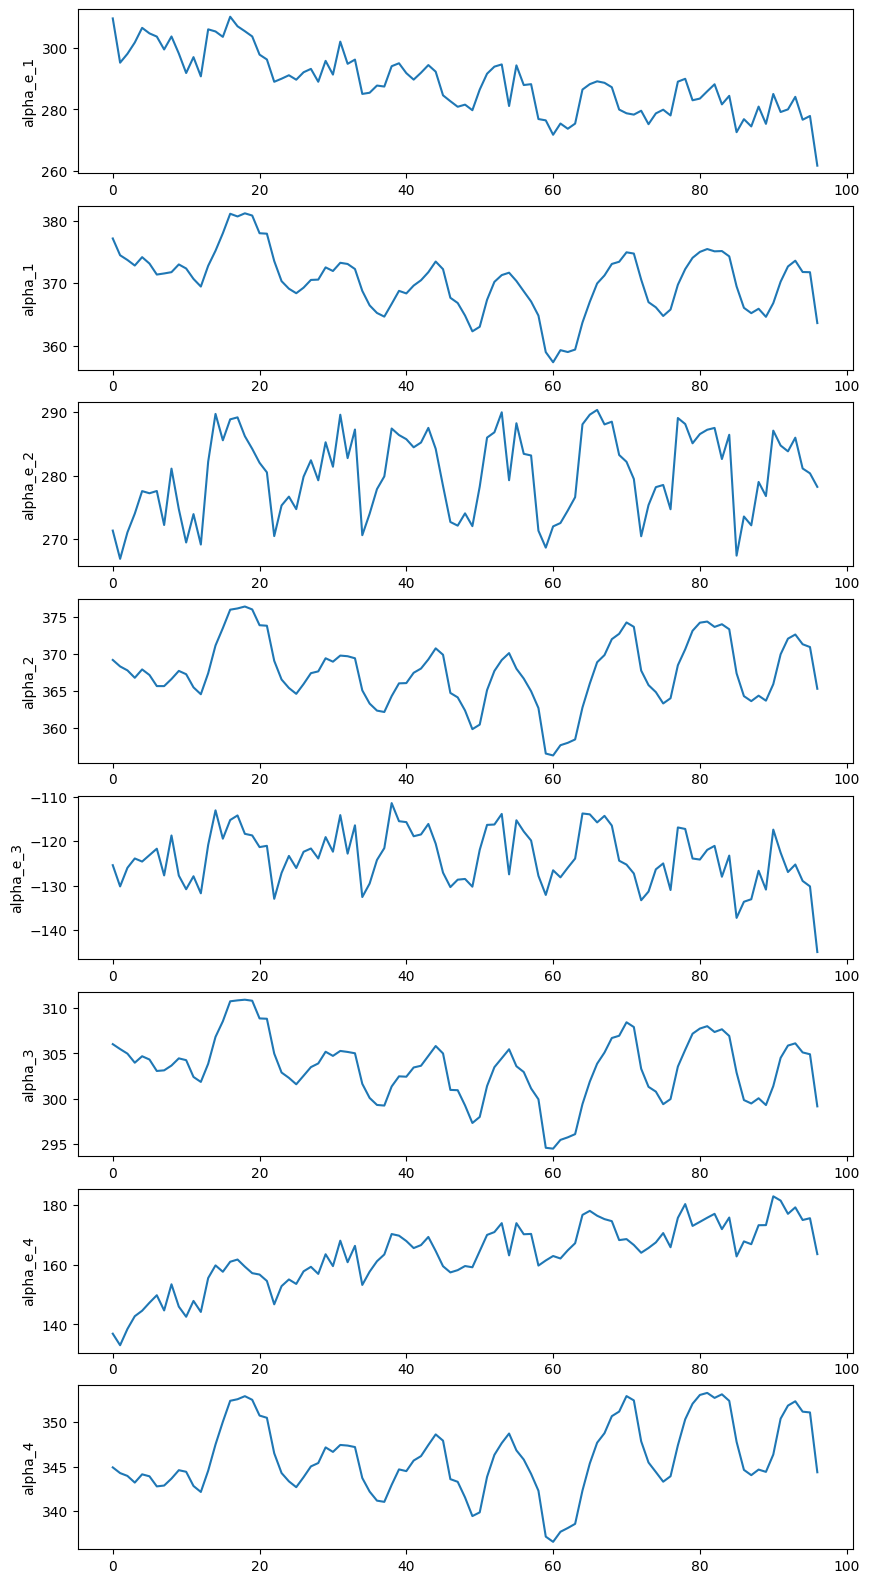

In [131]:
fig, axs = plt.subplots(8,1, figsize=(10,20))
st = 0

# take only 3 first periods
for k, v in list(df_tps.items())[:1]:
    X = np.arange(0+st, len(v) + st, 1)
    axs[0].plot(X, v["alpha_e_1"], label=k)
    axs[0].set_ylabel("alpha_e_1")
    
    axs[1].plot(X, v["alpha_1"], label=k)
    axs[1].set_ylabel("alpha_1")
    
    axs[2].plot(X, v["alpha_e_2"], label=k)
    axs[2].set_ylabel("alpha_e_2")
    
    axs[3].plot(X, v["alpha_2"], label=k)
    axs[3].set_ylabel("alpha_2")
    
    axs[4].plot(X, v["alpha_e_3"], label=k)
    axs[4].set_ylabel("alpha_e_3")
    
    axs[5].plot(X, v["alpha_3"], label=k)
    axs[5].set_ylabel("alpha_3")
    
    axs[6].plot(X, v["alpha_e_4"], label=k)
    axs[6].set_ylabel("alpha_e_4")
    
    axs[7].plot(X, v["alpha_4"], label=k)
    axs[7].set_ylabel("alpha_4")
 
    
    st += len(v)